In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import time
import torch
from scipy.stats import norm, laplace
import copy
plt.rcParams['figure.dpi'] = 200

import json
import shutil
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Run this code cell to train MNIST neural network. Do not modify.
import torch
import os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# README
This Python Notebook encapsulates our approach to implementing Quantile Quantization alongside the accompanying approaches of Uniform Quantization and Piecewise Linear Quantization. In each section denoted within the table of contents, we dictate what's specifically performed. Broadly, we test and evaluate these quantization methods initially on a random sample of training/test data and then implement the accuracy assessment on more complex models in GoogLeNet, MobileNetv3, and ResNet 50 utilizing ImageNet data. 

For more questions and concern, please direct them at the authors: Ralph Estanboulieh (ralphestanboulie@college.harvard.edu), Luke Kenworthy (lukekenworthy@college.harvard.edu), and Ryan Kim (ryankim@college.harvard.edu). 

# Quantile Quantization

1. Show that the ECDF works
2. Implement QQ, UQ, and PWLQ
3. Compare MSEs
4. Compare performance on different networks

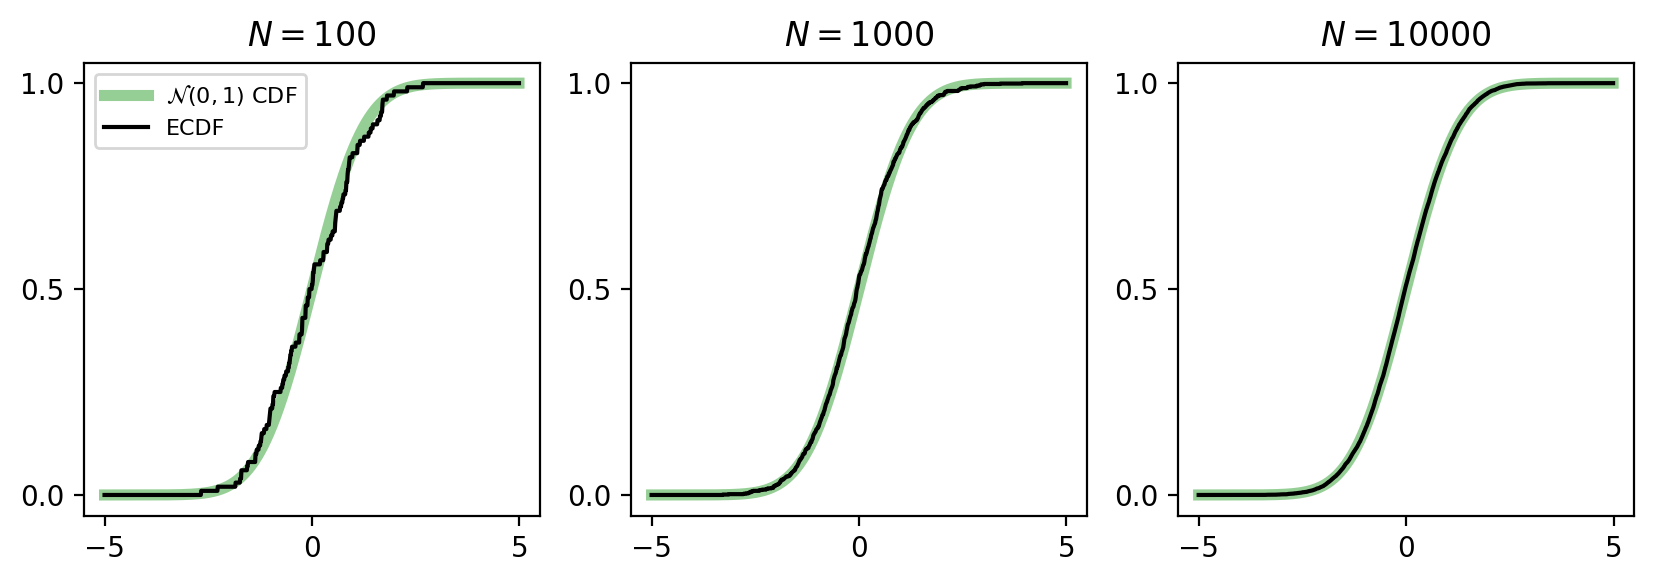

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (10, 3))
x = np.arange(-5,5,0.01)
sizes = [100, 1000, 10000]

for idx, ax in enumerate(axes):
  ax.plot(x, stats.norm.cdf(x), lw = 4, color = 'tab:green', alpha = 0.5)
  ecdf = ECDF(stats.norm.rvs(loc = 0, scale = 1, size = sizes[idx]))
  ax.plot(x, ecdf(x), color = 'k');
  ax.set_title(r'$N = %i$' % sizes[idx])
  ax.set_yticks([0, 0.5, 1])
  ax.set_xticks([-5, 0, 5])

axes[0].legend([r'$\mathcal{N}(0, 1)$ CDF', 'ECDF'], fontsize = 8);

In [ ]:
class QQ:
  def __init__(self, data, bits):
    '''
    Inputs
    --------------------------------------------------------------------------------
    data     | ARRAY (Numpy or Numpy-like) | The data to train the quantizer with
    M        | INTEGER                     | The number of quantizations to create
    '''
    self.data = data.copy()
    K = 2 ** bits

    # quantiles for the bins and the L1 quantizations
    self.q_bins = np.arange(0, 1 + 0.25/K, 1/K) 
    self.q_quants = np.arange(0.5/K, 1, 1/K)

    # find the actual quantile values
    self.quantizations = np.quantile(a = self.data, q = self.q_quants)
    self.bins = np.quantile(a = self.data, q = self.q_bins)

    # to accept any real number, make lower and upper bin bounds -/+ infinity
    self.mod_bins = self.bins.copy()
    self.mod_bins[0] = -np.inf
    self.mod_bins[-1] = +np.inf

    # compute the L2 quantizations
    bin_idx = np.digitize(x = data, bins = self.mod_bins)
    self.l2_quantizations = np.array([self.data[bin_idx == i+1].mean() for i in range(K)])

    self.mid_quantizations = (self.bins[:-1] + self.bins[1:]) / 2

  def quantize(self, array, qtype = 'l1'):
    '''
    Inputs
    --------------------------------------------------------------------------------
    data     | ARRAY (Numpy or Numpy-like)       | The data to quantize
    qtype    | STRING in {'l1', 'l2', 'middle'}  | The quantization value type 

    * Type 'l1' returns the median of each bin, which minimizes L1 (absolute value) loss. 
    * Type 'l2' returns the mean of each bin, which minimizes L2 (squared) loss.
    '''

    # digitize the array by finding the bin that contains each element
    bin_idx = np.digitize(x = array, bins = self.mod_bins)

    # return the corresponding quantization
    if qtype == 'l1':
        return self.quantizations[bin_idx - 1]
    elif qtype == 'middle':
        return self.mid_quantizations[bin_idx - 1]
    elif qtype == 'l2':
        return self.l2_quantizations[bin_idx - 1] 




In [ ]:
# TODO: Implement UQ below

class UQ:
  def __init__(self, data, bits):
    '''
    Inputs
    --------------------------------------------------------------------------------
    data     | ARRAY (Numpy or Numpy-like) | The data to train the quantizer with
    K        | INTEGER                     | The number of quantizations to create
    '''
    self.data = data
    self.K = 2 ** bits
    self.r_min, self.r_max = data.min(), data.max()
    self.range = self.r_max - self.r_min
    self.delta = self.range / self.K
    # Added because I was getting an error where it would try to go from 1 to 1 with a step size of 0
    if self.r_min != self.r_max + self.delta/2:
      self.bins = np.arange(self.r_min, self.r_max + self.delta/2, self.delta)
    else:
      self.bins = np.array([self.r_min, self.r_min])


    self.mod_bins = self.bins.copy()
    self.mod_bins[0] = -np.inf
    self.mod_bins[-1] = +np.inf

    if self.r_min + self.delta/2 != self.r_max:
        self.quantizations = np.arange(self.r_min + self.delta/2, self.r_max, self.delta)
    else:
        self.quantizations = np.array([self.r_max])
  def quantize(self, array):
    '''
    Inputs
    --------------------------------------------------------------------------------
    data     | ARRAY (Numpy or Numpy-like) | The data to quantize
    '''

    bin_idx = np.digitize(x = array, bins = self.mod_bins)

    return self.quantizations[bin_idx - 1]

# TODO: Implement PWLQ

class PWLQ:
  def __init__(self, data, bits):
    '''
    Inputs
    --------------------------------------------------------------------------------
    data     | ARRAY (Numpy or Numpy-like) | The data to train the quantizer with
    bits        | INTEGER                     | The number of bits
    '''
    self.data = data
    self.bits = bits
    self.breakpoint = 0
  
  def derivative_quant_err(self, m, p, dist='norm'):  
    '''
    Compute the derivative of expected variance of quantization error
    '''
    if dist == 'norm':
        cdf_func = norm.cdf(p)
        pdf_func = norm.pdf(p)
    elif dist == 'laplace':  
        # https://en.wikipedia.org/wiki/Laplace_distribution
        cdf_func = laplace.cdf(p, 0, np.sqrt(0.5))   
        pdf_func = laplace.pdf(p, 0, np.sqrt(0.5)) # pdf(p, a, b) has variance 2*b^2
    else:
        raise RuntimeError("Not implemented for distribution: %s !!!" % dist) 
    
    ## non-overlapping
    # quant_err = [F(p) - F(-p)] * p^2 + 2*[F(m) - F(p)] * (m - p)^2
    df_dp = p - 2 * m + 2 * m * cdf_func + m * pdf_func * (2 * p - m) 
    return df_dp

  def gradient_descent(self, m, dist, lr=0.1, max_iter=100, tol=1e-3):
    '''
    Gradient descent method to find the optimal breakpoint
    '''
    p = m / 2.0
    err, iter_num = 1, 0
    while err > tol and iter_num < max_iter:
        grad = self.derivative_quant_err(m, p, dist=dist)
        p = p - lr * grad
        err = np.abs(grad)
        iter_num += 1
    return p
  
  def binary_search(self, m, dist, max_iter=100, tol=1e-3):
    '''
    Binary search method to find the optimal breakpoint
    '''
    left, right = 0, m
    fl = self.derivative_quant_err(m, left, dist=dist)
    fr = self.derivative_quant_err(m, right, dist=dist)
    err, iter_num = 1, 0
    while err > tol and iter_num < max_iter:
        mid = (right - left) / 2.0 + left
        fm = self.derivative_quant_err(m, mid, dist=dist)
        if fm * fl > 0:
            left = mid
            fl = fm
        else:
            right = mid
            fr = fm
        err = np.abs(fm)
        iter_num += 1
    return mid 

  def find_optimal_breakpoint(self, m, dist='norm', approximate=True):
    '''
    Find the optimal breakpoint for PWLQ: approximated VS numerical solution
    '''
    m = float(m)
    ## linear approximated solution O(1)
    if approximate:
        assert(dist in ['norm', 'laplace'])
        if dist.startswith('norm'):
            # Approximated version for Gaussian
            coef = 0.86143114  
            inte = 0.607901097496529 
            break_point = np.log(coef * m + inte)
        elif dist.startswith('laplace'):
            # Approximated version for Laplacian
            coef = 0.80304483
            inte = -0.3166785508381478
            break_point = coef * np.sqrt(m) + inte
    ## numeric solution: gradient descent or binary search
    else:
        # here we use binary search: O(log m)
        break_point = self.binary_search(m, dist)
        # # or we can use gradient descent
        # break_point = self.gradient_descent(m, dist)

    ## add ramdon noise
    if 'noise' in dist:
        noise = abs(float(dist.split('-')[-1]))
        rand_num = np.random.uniform(-1.0, 1.0)
        random_noise = noise if rand_num >= 0.0 else -1.0 * noise
        break_point *= (1 + random_noise)

    return break_point
  
  def uniform_symmetric_quantizer(self, x, bits=8.0, minv=None, maxv=None, signed=True, 
                                scale_bits=0.0, num_levels=None, scale=None, simulated=True):
    if minv is None:
        maxv = torch.max(torch.abs(x))
        minv = - maxv if signed else 0

    if signed:
        maxv = np.max([-float(minv), float(maxv)])
        minv = - maxv 
    else:
        minv = 0
    
    if num_levels is None:
        num_levels = 2 ** bits

    if scale is None:
        scale = (maxv - minv) / (num_levels - 1)

    if scale_bits > 0:
        scale_levels = 2 ** scale_bits
        scale = torch.round(torch.mul(scale, scale_levels)) / scale_levels
            
    ## clamp
    x = torch.clamp(x, min=float(minv), max=float(maxv))
        
    x_int = torch.round(x / scale)
    
    if signed:
        x_quant = torch.clamp(x_int, min=-num_levels/2, max=num_levels/2 - 1)
        assert(minv == - maxv)
    else:
        x_quant = torch.clamp(x_int, min=0, max=num_levels - 1)
        assert(minv == 0 and maxv > 0)
        
    x_dequant = x_quant * scale
    
    return x_dequant if simulated else x_quant

  def uniform_affine_quantizer(self, x, bits=8.0, minv=None, maxv=None, offset=None, include_zero=False,
                            scale_bits=0.0, num_levels=None, scale=None, simulated=True):
    if minv is None:
        maxv = torch.max(x)
        minv = torch.min(x)
        if include_zero:
            if minv > 0:
                minv = 0
            elif maxv < 0:
                maxv = 0
    
    if num_levels is None:
        num_levels = 2 ** bits
    
    if not scale:
        scale = (maxv - minv) / (num_levels - 1)

    if not offset:
        offset =  minv

    if scale_bits > 0:
        scale_levels = 2 ** scale_bits
        scale = torch.round(torch.mul(scale, scale_levels)) / scale_levels
        offset = torch.round(torch.mul(offset, scale_levels)) / scale_levels
        
    ## clamp
    x = torch.clamp(x, min=float(minv), max=float(maxv))
        
    x_int = torch.round((x - offset) / scale)
    
    x_quant = torch.clamp(x_int, min=0, max=num_levels - 1)
        
    x_dequant = x_quant * scale + offset
    
    return x_dequant if simulated else x_quant
  
  def pwlq_quant_error(self, w, bits, scale_bits, abs_max, break_point):
    '''
    Piecewise linear quantization (PWLQ) with one option: non-overlapping
    '''
    qw_tail_neg = self.uniform_affine_quantizer(w, 
        bits=bits-1, scale_bits=scale_bits, minv=-abs_max, maxv=-break_point)
    qw_tail_pos = self.uniform_affine_quantizer(w, 
        bits=bits-1, scale_bits=scale_bits, minv=break_point, maxv=abs_max)
    qw_middle = self.uniform_symmetric_quantizer(w, 
        bits=bits, scale_bits=scale_bits, minv=-break_point, maxv=break_point)

    qw = torch.where(-break_point < w, qw_middle, qw_tail_neg)
    qw = torch.where(break_point > w, qw, qw_tail_pos)

    err = torch.sqrt(torch.sum(torch.mul(qw - w, qw - w)))
    return err, qw

  def pwlq_coarse2fine_grid_search(self, w, bits=4.0, scale_bits=0.0, search_range=10):
      '''
      Coarse-to-fine grid search for optimal breakpoint to minimize the quantization error
      Search for optimal breakpoint ratio: bkp_ratio = break_point / abs_max
      '''
      min_err = 10000
      abs_max = torch.max(torch.abs(w))
      
      ## first stage
      for bkp_ratio in np.arange(0.1, 1.0, 0.1):
          break_point = bkp_ratio * abs_max
          err, qw = self.pwlq_quant_error(w, bits, scale_bits, abs_max, break_point)
          if err < min_err:
              min_err = err
              best_ratio = bkp_ratio
              best_qw = qw

      ## second stage
      ratio_start, ratio_end = best_ratio - 0.01 * search_range, best_ratio + 0.01 * search_range
      for bkp_ratio in np.arange(ratio_start, ratio_end, 0.01):
          break_point = bkp_ratio * abs_max
          err, qw = self.pwlq_quant_error(w, bits, scale_bits, abs_max, break_point)
          if err < min_err:
              min_err = err
              best_ratio = bkp_ratio
              best_qw = qw

      ## third stage
      ratio_start, ratio_end = best_ratio - 0.001 * search_range, best_ratio + 0.001 * search_range
      for bkp_ratio in np.arange(ratio_start, ratio_end, 0.001):
          break_point = bkp_ratio * abs_max
          err, qw = self.pwlq_quant_error(w, bits, scale_bits, abs_max, break_point)
          if err < min_err:
              min_err = err
              best_ratio = bkp_ratio
              best_qw = qw
          
      return best_qw, best_ratio, min_err

  def piecewise_linear_quant(self, w, bits=4.0, scale_bits=0.0, break_point_approach='norm', approximate=False):
    '''
    Piecewise Linear Quantization (PWLQ)
    '''
    if break_point_approach == 'search': 
        ## coarse-to-fine grid search for minimizing quantization error
        qw, bkp_ratio, err = self.pwlq_coarse2fine_grid_search(w, 
                                bits=bits, scale_bits=scale_bits)
    else:
        ## assumption: w is stastifying Gaussian or Laplacian distribution
        # break_point_approach = 'norm' (Gaussian) or 'laplace' (Laplacian)
        std_w = torch.std(w) + 1e-12
        abs_max = torch.max(torch.abs(w))
        abs_max_normalized = abs_max / std_w
        break_point_normalized = self.find_optimal_breakpoint(abs_max_normalized, dist=break_point_approach, approximate=approximate)
        bkp_ratio = break_point_normalized / abs_max_normalized
        break_point = bkp_ratio * abs_max
        
        # update self values
        self.breakpoint = break_point
        
        err, qw = self.pwlq_quant_error(w, bits, scale_bits, abs_max, break_point)
    return qw, bkp_ratio, err
    

## Testing and evaluation (with toy data)

Where many figures are born.

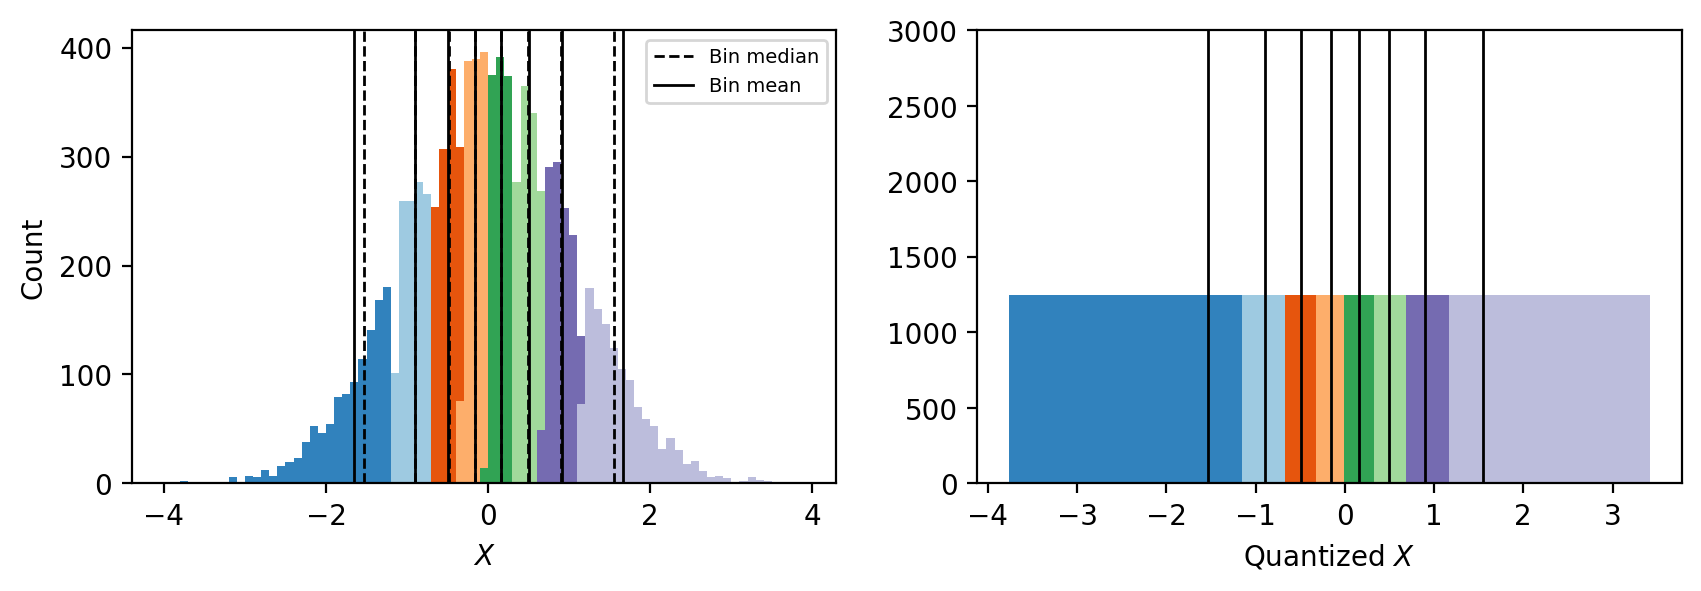

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

ax = axes[0]

X = stats.norm.rvs(size = 10000)
QQX = QQ(X, 3)
X_q = QQX.quantize(X)

ax.set_prop_cycle(color = plt.get_cmap("tab20c").colors[::2])

for idx, q in enumerate(QQX.quantizations):
    ax.hist(X[X_q == q], bins = np.arange(-4, 4, 0.1))
    l1 = ax.axvline(x = q, lw = 1, linestyle = '--', color = 'k')
    l2 = ax.axvline(x = QQX.l2_quantizations[idx], lw = 1, color = 'k')

ax.legend(handles = (l1, l2), labels = ['Bin median', 'Bin mean'], fontsize = 7)
ax.set_xlabel(r'$X$')
ax.set_ylabel('Count');

ax = axes[1]

ax.set_prop_cycle(color = plt.get_cmap("tab20c").colors[::2])

for idx, q in enumerate(QQX.quantizations):
    ax.hist(X[X_q == q], bins = QQX.bins)
    l1 = ax.axvline(x = q, lw = 1, linestyle = '-', color = 'k')
    # l2 = ax.axvline(x = QQX.l2_quantizations[idx], lw = 1, color = 'k')
ax.set_ylim([0, 3000])
ax.set_xlabel(r'Quantized $X$');


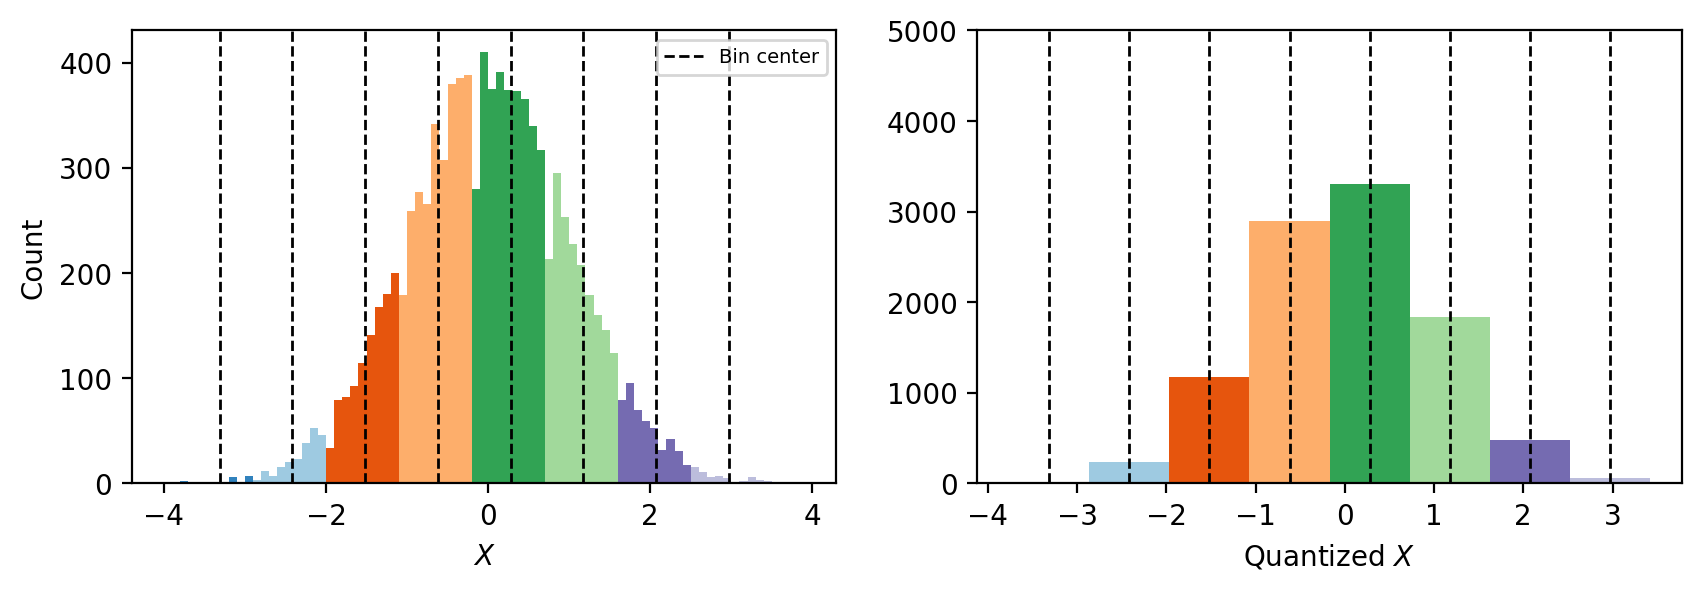

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

ax = axes[0]

UQX = UQ(X, 3)
X_uq = UQX.quantize(X)

ax.set_prop_cycle(color = plt.get_cmap("tab20c").colors[::2])

for idx, q in enumerate(UQX.quantizations):
    ax.hist(X[X_uq == q], bins = np.arange(-4, 4, 0.1))
    l1 = ax.axvline(x = q, lw = 1, linestyle = '--', color = 'k')

ax.legend(handles = (l1, l2), labels = ['Bin center'], fontsize = 7)
ax.set_xlabel(r'$X$')
ax.set_ylabel('Count');

ax = axes[1]

ax.set_prop_cycle(color = plt.get_cmap("tab20c").colors[::2])

for idx, q in enumerate(UQX.quantizations):
    ax.hist(X[X_uq == q], bins = UQX.bins)
    l1 = ax.axvline(x = q, lw = 1, linestyle = '--', color = 'k')
ax.set_ylim([0, 5000])
ax.set_xlabel(r'Quantized $X$');


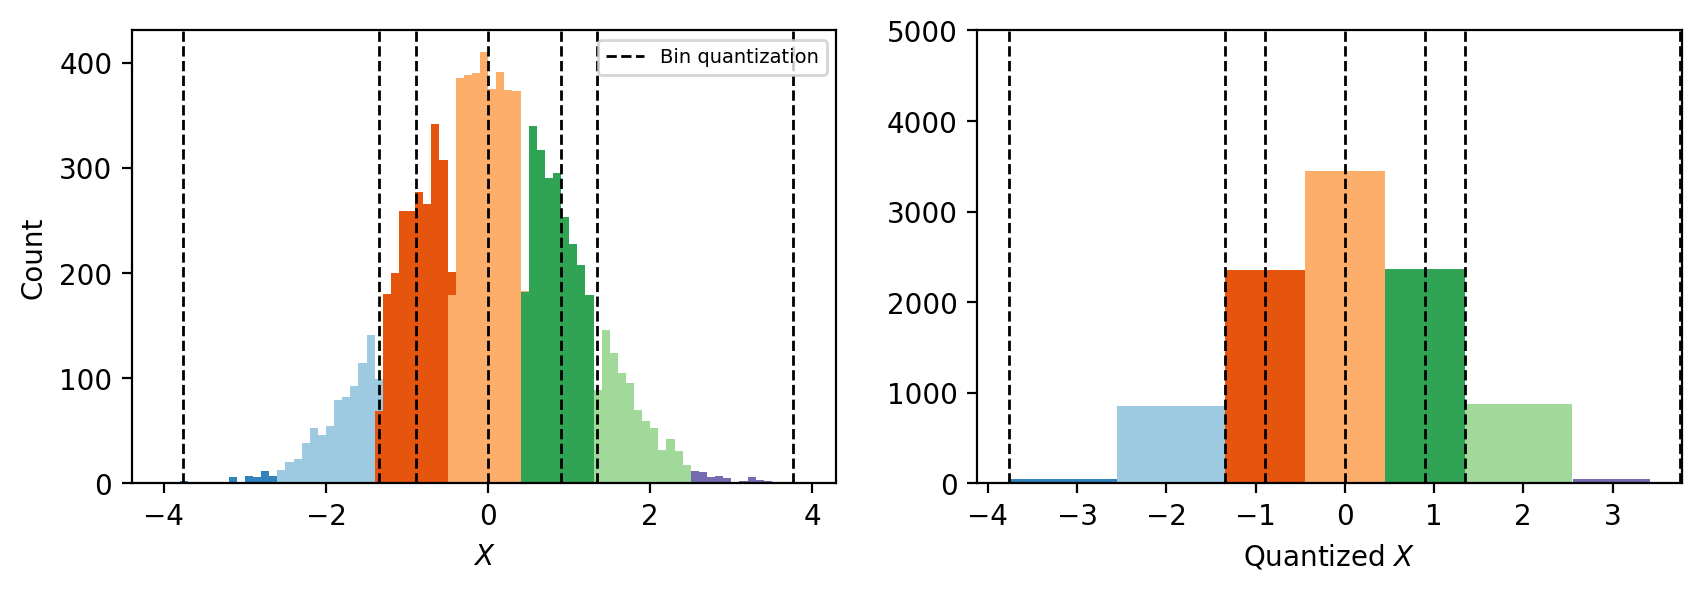

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

ax = axes[0]

quantizer = PWLQ(torch.Tensor(X), bits=2)
X_pwlq = quantizer.piecewise_linear_quant(torch.Tensor(X), bits=2)[0]

ax.set_prop_cycle(color = plt.get_cmap("tab20c").colors[::2])

quants = np.sort(np.array(list(set(X_pwlq.numpy()))))

for idx, q in enumerate(quants):
    ax.hist(X[X_pwlq == q], bins = np.arange(-4, 4, 0.1))
    l1 = ax.axvline(x = q, lw = 1, linestyle = '--', color = 'k')

ax.legend(handles = (l1, l2), labels = ['Bin quantization'], fontsize = 7)
ax.set_xlabel(r'$X$')
ax.set_ylabel('Count');

ax = axes[1]

ax.set_prop_cycle(color = plt.get_cmap("tab20c").colors[::2])

for idx, q in enumerate(quants):
    ax.hist(X[X_pwlq == q], bins = [X[X_pwlq == q].min(), X[X_pwlq == q].max()])
    l1 = ax.axvline(x = q, lw = 1, linestyle = '--', color ='k')
ax.set_ylim([0, 5000])
ax.set_xlabel(r'Quantized $X$');


Looking at the MSE loss for QQ and UQ

In [ ]:
Ms = np.arange(1,9)
N = 10000
X = stats.norm.rvs(size = N)
L2_loss = {'qq':[], 'uq':[], 'pwlq':[]}
L1_loss = {'qq':[], 'uq':[], 'pwlq':[]}



for M in Ms:
    QQuant = QQ(X, M)
    UQuant = UQ(X, M)
    PWLQant = PWLQ(torch.Tensor(X), bits= max(M-1, 2))

    X_pwlq = PWLQant.piecewise_linear_quant(torch.Tensor(X), bits= max(M-1, 2))[0]
    X_qq = QQuant.quantize(X, 'l2')
    X_uq = UQuant.quantize(X)

    L2_loss['pwlq'].append(np.linalg.norm(X - X_pwlq.numpy())/N)
    L2_loss['qq'].append(np.linalg.norm(X - X_qq)/N)
    L2_loss['uq'].append(np.linalg.norm(X - X_uq)/N)

    L1_loss['pwlq'].append(np.abs(X - X_pwlq.numpy()).sum()/N)
    L1_loss['qq'].append(np.abs(X - X_qq).sum()/N)
    L1_loss['uq'].append(np.abs(X - X_uq).sum()/N)


In [ ]:
bits = 3
X.sort()
QQuant = QQ(X, bits)
UQuant = UQ(X, bits)
PWLQuant = PWLQ(X, bits-1)

X_qq = QQuant.quantize(X, 'l2')
X_uq = UQuant.quantize(X)
X_pwlq = PWLQant.piecewise_linear_quant(torch.Tensor(X), bits = bits-1)[0]

In [ ]:
print(X_qq.var() - 2*np.cov(np.stack((X.T, X_qq.T), axis = 0))[0, 1])
print(X_uq.var() - 2*np.cov(np.stack((X.T, X_uq.T), axis = 0))[0, 1])
print(X_pwlq.var() - 2*np.cov(np.stack((X.T, X_pwlq.T), axis = 0))[0, 1])

-0.9534699081028869
-0.9293628266917322
tensor(-0.8992)


In [ ]:
print(np.cov(np.stack((X.T, X_uq.T), axis = 0))[0, 1])
print(np.cov(np.stack((X.T, X_qq.T), axis = 0))[0, 1])
print(np.cov(np.stack((X.T, X_pwlq.T), axis = 0))[0, 1])


1.0055880759854932
0.9533745706458221
0.8613968909818285


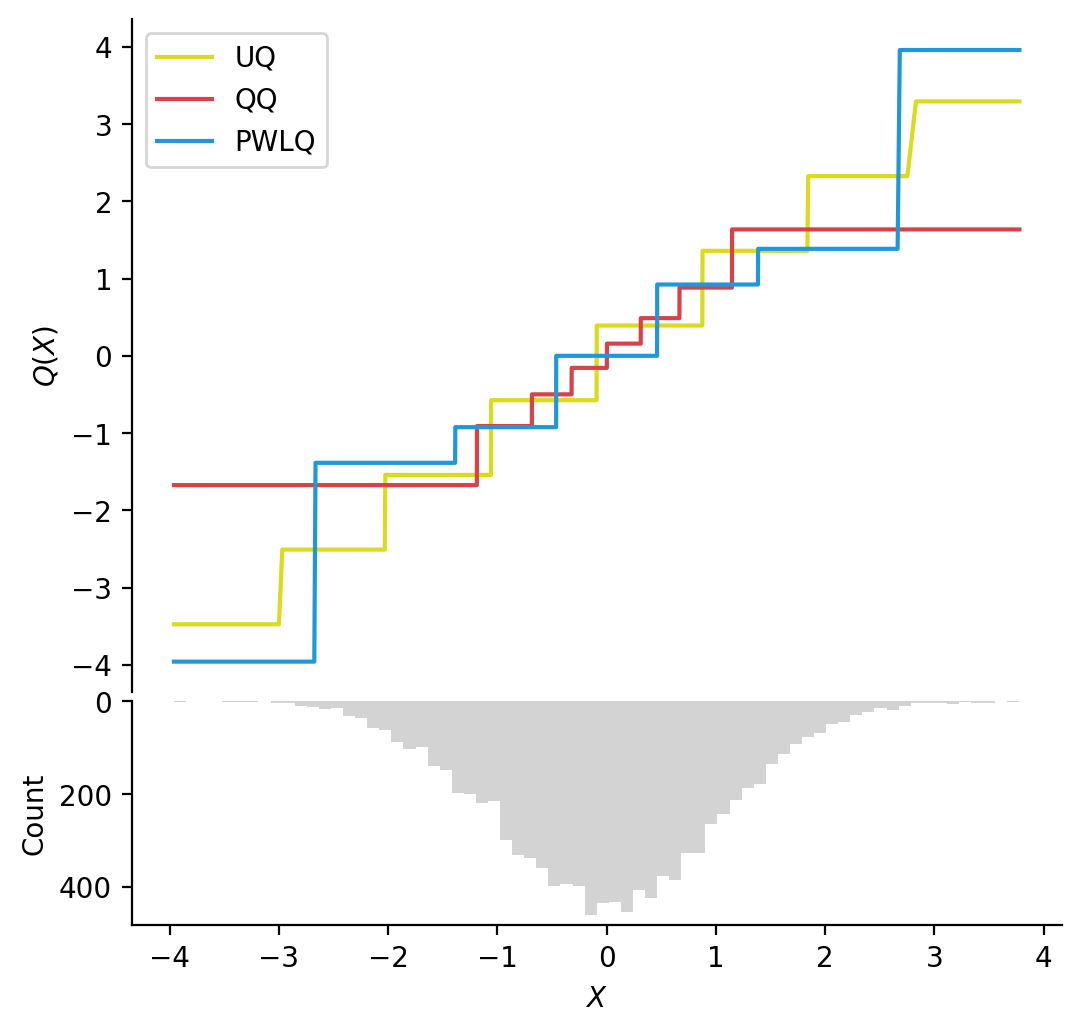

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (6, 6), gridspec_kw={'height_ratios': [3, 1]})

ax = axes[0]
ax.plot(X, X_uq, color = '#D9DB1B')
ax.plot(X, X_qq, color = '#DB4047')
ax.plot(X, X_pwlq, color = '#1F98DB')
ax.legend(['UQ', 'QQ', 'PWLQ'])
ax.set_ylabel(r'$Q(X)$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])

ax = axes[1]
ax.hist(X, bins = 70, color = "lightgrey")
ax.invert_yaxis()
ax.set_xlabel(r'$X$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Count')
fig.subplots_adjust(hspace=0.02)

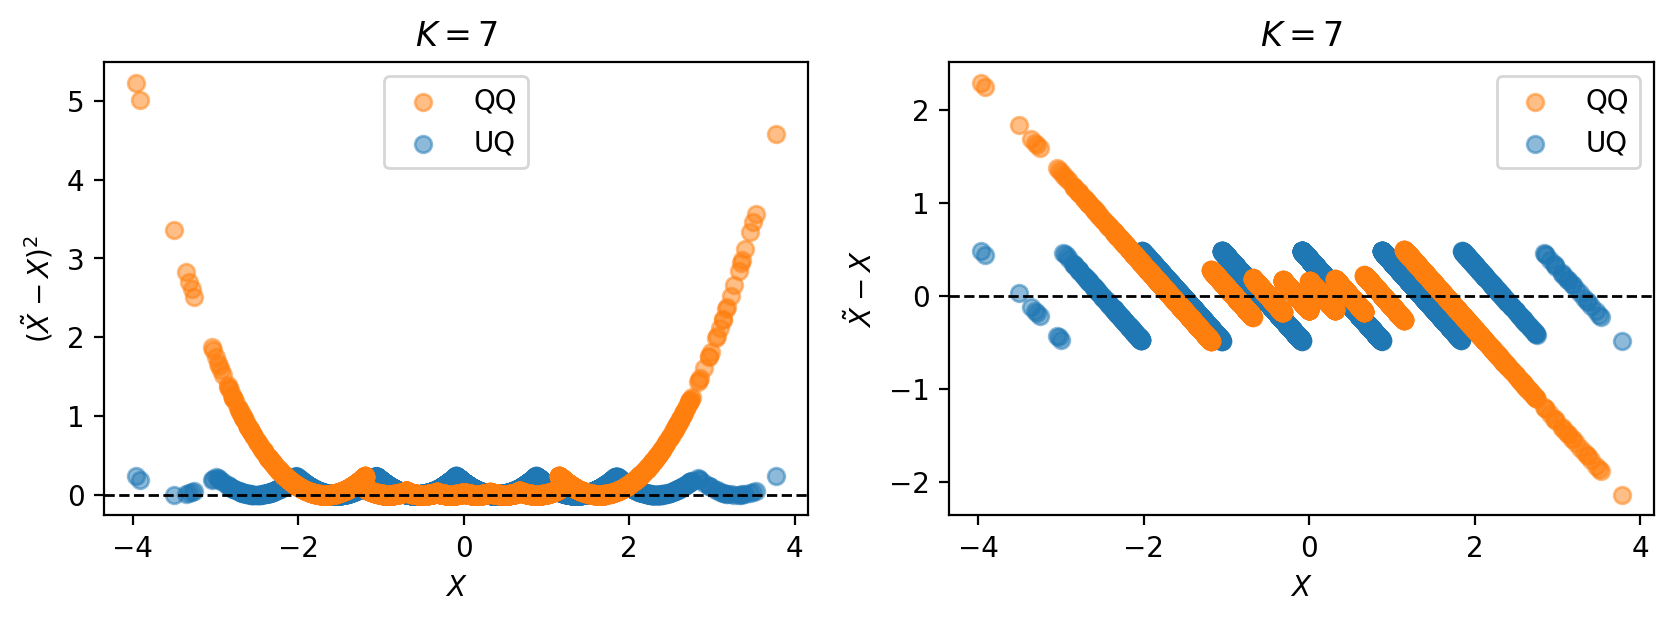

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10, 3))

ax = axes[0]
uqPlot = ax.scatter(X, (X - X_uq)**2, alpha = 0.5)
qqPlot = ax.scatter(X,(X - X_qq)**2, alpha = 0.5)

ax.axhline(0, lw = 1, linestyle = 'dashed', color = 'k')
ax.set_title(r'$K = 7$')
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$(\tilde X - X)^2$')
ax.legend((qqPlot, uqPlot), ['QQ', 'UQ']);

ax = axes[1]
uqPlot = ax.scatter(X,(X_uq - X).flatten(), alpha = 0.5)
qqPlot = ax.scatter(X,(X_qq - X).flatten(), alpha = 0.5)

ax.axhline(0, lw = 1, linestyle = 'dashed', color = 'k')
ax.set_title(r'$K = 7$')
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$\tilde X - X$')
ax.legend((qqPlot, uqPlot), ['QQ', 'UQ']);


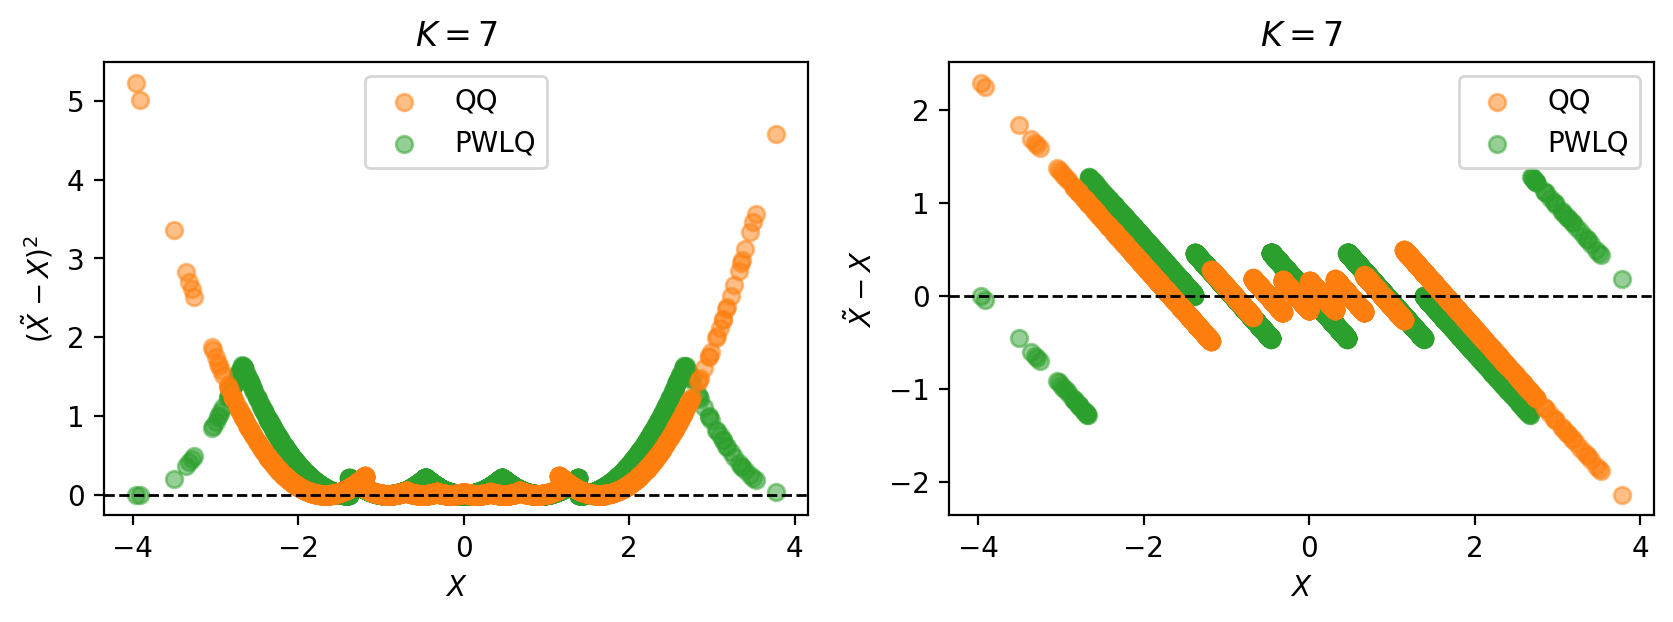

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10, 3))

ax = axes[0]
uqPlot = ax.scatter(X.flatten(),(X - X_pwlq.numpy())**2, alpha = 0.5, color = 'tab:green')
qqPlot = ax.scatter(X.flatten(),(X - X_qq)**2, alpha = 0.5, color = 'tab:orange')

ax.axhline(0, lw = 1, linestyle = 'dashed', color = 'k')
ax.set_title(r'$K = 7$')
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$(\tilde X - X)^2$')
ax.legend((qqPlot, uqPlot), ['QQ', 'PWLQ']);

ax = axes[1]
uqPlot = ax.scatter(X.flatten(),(X_pwlq.numpy() - X).flatten(), alpha = 0.5, color = 'tab:green')
qqPlot = ax.scatter(X.flatten(),(X_qq - X).flatten(), alpha = 0.5, color = 'tab:orange')

ax.axhline(0, lw = 1, linestyle = 'dashed', color = 'k')
ax.set_title(r'$K = 7$')
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$\tilde X - X$')
ax.legend((qqPlot, uqPlot), ['QQ', 'PWLQ']);


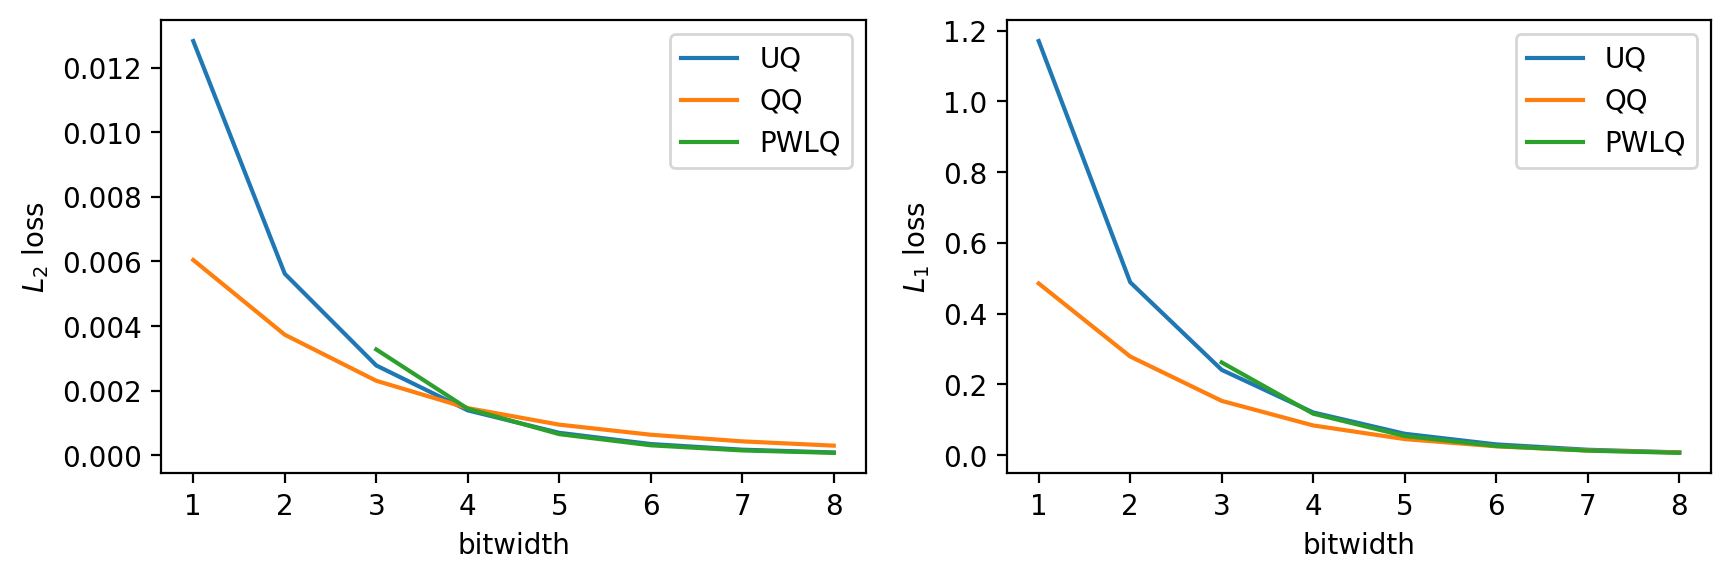

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10, 3))

ax = axes[0]
ax.plot(Ms, L2_loss['uq'])
ax.plot(Ms, L2_loss['qq'])
ax.plot(Ms[2:], L2_loss['pwlq'][2:])

ax.set_xlabel(r'bitwidth')
ax.set_ylabel(r'$L_2$ loss')
ax.legend(['UQ', 'QQ', 'PWLQ']);

ax = axes[1]
ax.plot(Ms, L1_loss['uq'])
ax.plot(Ms, L1_loss['qq'])
ax.plot(Ms[2:], L1_loss['pwlq'][2:])

ax.set_xlabel(r'bitwidth')
ax.set_ylabel(r'$L_1$ loss')
ax.legend(['UQ', 'QQ', 'PWLQ']);

fig.subplots_adjust(wspace=0.2)

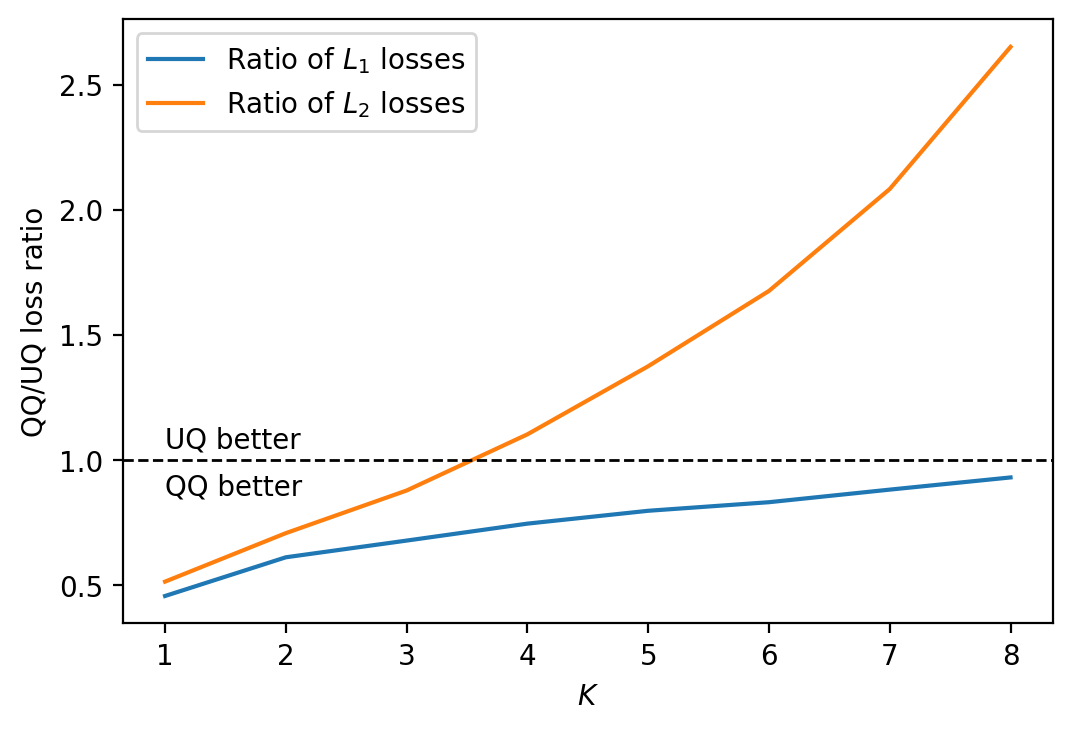

In [ ]:
fig, ax = plt.subplots()

l1 = ax.plot(Ms, np.array(L1_loss['qq'])/np.array(L1_loss['uq']))
l2 = ax.plot(Ms, np.array(L2_loss['qq'])/np.array(L2_loss['uq']))

ax.axhline(1, lw = 1, linestyle = 'dashed', color = 'k')
ax.text(1, 1.05, 'UQ better')
ax.text(1, 0.86, 'QQ better')

ax.set_xlabel(r'$K$')
ax.set_ylabel('QQ/UQ loss ratio')
ax.legend([r'Ratio of $L_1$ losses', r'Ratio of $L_2$ losses']);

In [ ]:
def quantize_model(model, bits, quant_type):

    model_copy = copy.deepcopy(model)

    model_copy.cpu()
    state_dict = model_copy.state_dict()
    quantized_dict = {}
    
    for key, tensor in state_dict.items():
        if not 'tracked' in key:
            if quant_type == "qq":
                array = tensor.numpy()
                quantizer = QQ(array, bits)
                weights = torch.from_numpy(quantizer.quantize(array, qtype='l2'))

            elif quant_type == "uq":
                array = tensor.numpy()
                quantizer = UQ(array, bits)
                weights = torch.from_numpy(quantizer.quantize(array))

            elif quant_type == "pwlq":
                quantizer = PWLQ(tensor, bits=bits-1)
                weights = quantizer.piecewise_linear_quant(tensor, bits=bits-1)[0]
        else:
          weights = tensor
      
        quantized_dict[key] = weights


    model_copy.load_state_dict(quantized_dict)
    model_copy.cuda()
    return model_copy

# Testing and evaluation (with actual models)

First, train a basic model on MNIST

In [ ]:
# Train an MNIST neural network. Run this code cell.
class MNISTNet(nn.Module):
    def __init__(self, hidden=128):
      super(MNISTNet, self).__init__()

      # First 2D convolutional layer, taking in 1 input channel (image),
      # outputting 32 convolutional features, with a square kernel size of 3
      self.hidden = hidden
      self.fc1 = nn.Linear(28*28*1, self.hidden)
      self.fc2 = nn.Linear(self.hidden, 10)

    def forward(self, x):
      x = x.view(-1, 28*28)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      return F.log_softmax(x, dim=1)

def train_mnist(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test_mnist(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)
    
device = torch.device("cpu")


In [ ]:
model = MNISTNet()

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1_mnist = datasets.MNIST('./data_mnist', train=True, download=True,
                    transform=transform)
dataset2_mnist = datasets.MNIST('./data_mnist', train=False,
                    transform=transform)
train_loader_mnist = torch.utils.data.DataLoader(dataset1_mnist)
test_loader_mnist = torch.utils.data.DataLoader(dataset2_mnist)


Extracting ./data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data_mnist/MNIST/raw




Extracting ./data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:


optimizer = optim.Adam(model.parameters())

scheduler = StepLR(optimizer, step_size=1, gamma=.1)
for epoch in range(1, 5):
    train_mnist(model, device, train_loader_mnist, optimizer, epoch)
    test_mnist(model, device, test_loader_mnist)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.468227
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.000515
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.000003
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.000061
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.000001
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.000003

Test set: Average loss: 0.2453, Accuracy: 9405/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.002962
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.000000
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.000000
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.000153
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.000001
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.000001

Test set: Average loss: 0.1263, Accuracy: 9698/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.007583
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.000000
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.000000
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.000022
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.000000
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

In [ ]:
# Save model
import pickle
state_dict = model.state_dict()
with open("trainedMNISTnet.pickle", "wb") as f:
    pickle.dump(state_dict, f)

In [ ]:
# load model
import pickle
model = MNISTNet()
with open("trainedMNISTnet.pickle", "rb") as f:
    model.load_state_dict(pickle.load(f))

In [ ]:
def quantize_model(model, bits, quant_type):
    model_copy = copy.deepcopy(model)
    state_dict = model.state_dict()
    quantized_dict = {}
    
    for i, tensor in state_dict.items():
        if quant_type == "qq":
            array = tensor.numpy()
            quantizer = QQ(array, bits)
            weights = torch.from_numpy(quantizer.quantize(array, qtype=reg))

        elif quant_type == "uq":
            array = tensor.numpy()
            quantizer = UQ(array, bits)
            weights = torch.from_numpy(quantizer.quantize(array))

        elif quant_type == "pwlq":
            quantizer = PWLQ(tensor, bits=bits-1)
            weights = quantizer.piecewise_linear_quant(tensor, bits=bits-1)[0]

        else:
            assert False, "Invalid quantization type"
  
        quantized_dict[i] = weights


    model_copy.load_state_dict(quantized_dict)

    return model_copy


In [ ]:
print("Baseline Score", end = "")
baseline_acc = test_mnist(model, device, test_loader_mnist)

quant_acc = {'qq':[], 'uq':[], 'pwlq':[]}

for bits in range(1, 9):

    print(f"UQ Quantized Score for bits = {bits}: ", end = "")
    uq_acc = test_mnist(quantize_model(model, bits, quant_type="UQ"), device, test_loader_mnist)

    print(f"QQ Quantized Score for bits = {bits}:", end = "")
    qq_acc = test_mnist(quantize_model(model, bits, quant_type="QQ", reg="l2"), device, test_loader_mnist)

    if bits >= 3:
        print(f"PWLQ Quantized Score for bits = {bits}:", end = "")
        pwlq_acc = test_mnist(quantize_model(model, bits, quant_type="PWLQ"), device, test_loader_mnist)
        quant_acc['pwlq'].append(pwlq_acc)


    quant_acc['qq'].append(qq_acc)
    quant_acc['uq'].append(uq_acc)


Baseline Score

NameError: ignored

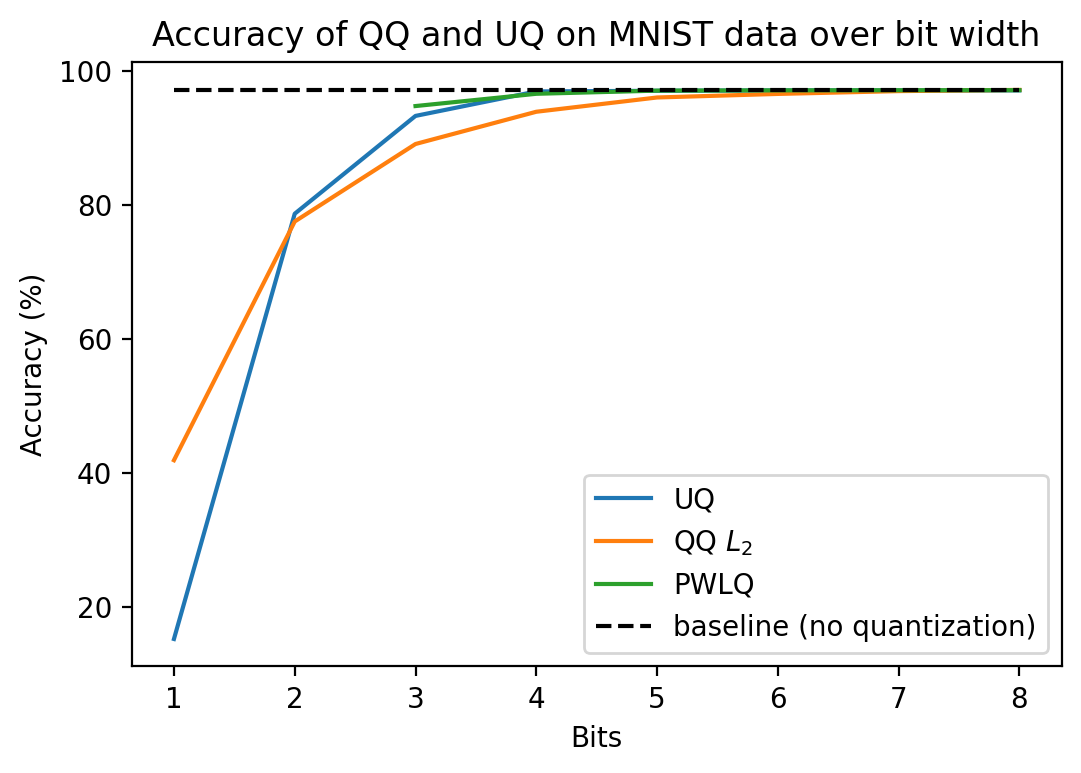

In [ ]:
x = np.arange(1, 9)
plt.title("Accuracy of QQ and UQ on MNIST data over bit width")
plt.plot(x, quant_acc['uq'], label="UQ")
plt.plot(x,  quant_acc['qq'], label=r"QQ $L_2$")
plt.plot(x[2:],  quant_acc['pwlq'], label="PWLQ")
plt.plot(x, [baseline_acc for _ in x], "k--", label="baseline (no quantization)")
plt.xlabel("Bits")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [ ]:
np.array(all_weights).std()

0.1371672

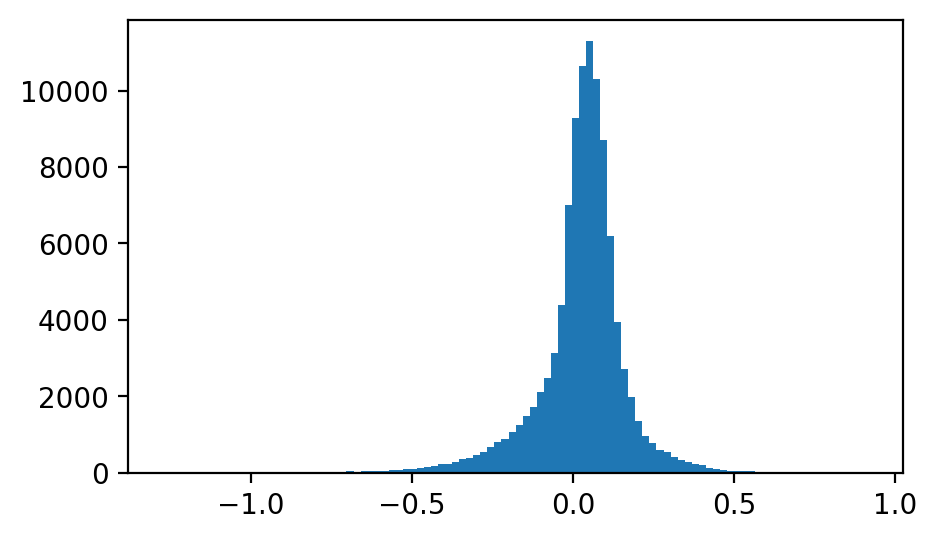

In [ ]:
state_dict = model.state_dict()
all_weights = []
for i, v in state_dict.items():
    weights = v.numpy()
    all_weights.extend(weights.flatten())

fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(all_weights, bins = 100);

In [ ]:
# Download resnet model
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import sys
from tqdm import tqdm
import os

device = torch.device("cuda")
resnet18 = models.resnet18(device).cuda()

In [ ]:
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                         num_workers=2)
print('Finished loading datasets!')

Files already downloaded and verified
Files already downloaded and verified
Finished loading datasets!


In [ ]:
best_acc = 0

def train(net, epoch, train_loss_tracker, train_acc_tracker):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # update optimizer state
        optimizer.step()
        # compute average loss
        train_loss += loss.item()
        train_loss_tracker.append(loss.item())
        loss = train_loss / (batch_idx + 1)
        # compute accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        # Print status
        sys.stdout.write(f'\rEpoch {epoch}: Train Loss: {loss:.3f}' +  
                         f'| Train Acc: {acc:.3f} | {batch_idx} data points in')
        sys.stdout.flush()
    train_acc_tracker.append(acc)
    sys.stdout.flush()

def test(net, epoch, test_loss_tracker, test_acc_tracker):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # inputs, targets = inputs.to(device), targets.to(device)
            # inputs, labels = data                         # this is what you had
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            test_loss_tracker.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()
    
    # Save checkpoint.
    acc = 100.*correct/total
    test_acc_tracker.append(acc)
    if acc > best_acc:
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [ ]:
with open("./checkpoint/ckpt.pth", "rb") as f:
    net = torch.load(f, device)["net"]
    resnet18.load_state_dict(net)

RuntimeError: ignored

In [ ]:
epochs = 50
lr = 0.001


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Records the training loss and training accuracy during training
train_loss_tracker, train_acc_tracker = [], []

# Records the test loss and test accuracy during training
test_loss_tracker, test_acc_tracker = [], []

print('Training for {} epochs, with learning rate {}'.format(
      epochs, lr))

start_time = time.time()
for epoch in range(epochs):
    train(resnet18, epoch, train_loss_tracker, train_acc_tracker)
    test(resnet18, epoch, test_loss_tracker, test_acc_tracker)
    scheduler.step()

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Training for 50 epochs, with learning rate 0.001
Epoch 0: Train Loss: 0.208| Train Acc: 92.834 | 390 data points in | Test Loss: 0.421 | Test Acc: 86.610
Epoch 1: Train Loss: 0.190| Train Acc: 93.490 | 390 data points in | Test Loss: 0.420 | Test Acc: 86.600
Epoch 2: Train Loss: 0.178| Train Acc: 94.054 | 390 data points in | Test Loss: 0.421 | Test Acc: 86.900
Epoch 3: Train Loss: 0.171| Train Acc: 94.198 | 390 data points in | Test Loss: 0.421 | Test Acc: 86.840
Epoch 4: Train Loss: 0.167| Train Acc: 94.294 | 390 data points in | Test Loss: 0.424 | Test Acc: 86.840
Epoch 5: Train Loss: 0.163| Train Acc: 94.442 | 390 data points in | Test Loss: 0.425 | Test Acc: 86.870
Epoch 6: Train Loss: 0.163| Train Acc: 94.450 | 390 data points in | Test Loss: 0.429 | Test Acc: 86.830
Epoch 7: Train Loss: 0.156| Train Acc: 94.712 | 390 data points in | Test Loss: 0.430 | Test Acc: 86.900
Epoch 8: Train Loss: 0.153| Train Acc: 94.814 | 390 data points in | Test Loss: 0.432 | Test Acc: 86.770
Epoch 

KeyboardInterrupt: ignored

In [ ]:
def cifar_test(net):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100.* correct / total
    print(acc)
    print()
    return acc

In [ ]:
def quantize_resnet_model(model, bits, quant_type="QQ", reg="l1"):
    state_dict = model.state_dict()
    quantized_dict = {}
    for i, tensor in state_dict.items():
        if not ("weight" in i or "bias" in i):
            quantized_dict[i] = tensor
            continue
        if quant_type == "QQ":
            array = tensor.cpu().numpy()
            quantizer = QQ(array, 2 ** bits)
            assert reg in {"l1", "l2", "middle"}, "Invalid reg type"
            if reg == "l1":
                weights = torch.from_numpy(quantizer.quantize(array))
            else:
                weights = torch.from_numpy(quantizer.quantize(array, qtype=reg))
        elif quant_type == "UQ":
            array = tensor.cpu().numpy()
            quantizer = UQ(array, 2 ** bits)
            weights = torch.from_numpy(quantizer.quantize(array))
        elif quant_type == "PWLQ":
            quantizer = PWLQ(tensor, bits=bits)
            weights = quantizer.piecewise_linear_quant(tensor, bits=bits)[0]
        else:
            assert False, "Invalid quantization type"
        
        quantized_dict[i] = weights
    quantized_model = models.resnet18(device).cuda()
    quantized_model.load_state_dict(quantized_dict)
    return quantized_model


In [ ]:
print("Baseline Score")
baseline_acc = cifar_test(resnet18)


qq_l1s = []
uq_accuracies = []
qq_l2s = []
qq_middles = []
pwlq_accuracies = []

for bits in range(1, 9):
    print(f"QQ Quantized Score for bits = {bits} (l1):")
    qql1_acc = cifar_test(quantize_resnet_model(resnet18, bits, quant_type="QQ", reg="l1"))

    print(f"UQ Quantized Score for bits = {bits}:")
    uq_acc = cifar_test(quantize_resnet_model(resnet18, bits, quant_type="UQ"))

    print(f"QQ Quantized Score for bits = {bits} (middle):")
    qqm_acc = cifar_test(quantize_resnet_model(resnet18, bits, quant_type="QQ", reg="middle"))

    print(f"QQ Quantized Score for bits = {bits} (l2):")
    qql2_acc = cifar_test(quantize_resnet_model(resnet18, bits, quant_type="QQ", reg="l2"))

    print(f"PWLQ Quantized Score for bits = {bits}:")
    pwlq_acc = cifar_test(quantize_resnet_model(resnet18, bits, quant_type="PWLQ"))

    qq_l1s.append(qql1_acc)
    uq_accuracies.append(uq_acc)
    qq_l2s.append(qql2_acc)
    qq_middles.append(qqm_acc)
    pwlq_accuracies.append(pwlq_acc)


Baseline Score
86.9

QQ Quantized Score for bits = 1 (l1):


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


10.0

UQ Quantized Score for bits = 1:
10.0

QQ Quantized Score for bits = 1 (middle):
10.0

QQ Quantized Score for bits = 1 (l2):
10.0

PWLQ Quantized Score for bits = 1:
10.0

QQ Quantized Score for bits = 2 (l1):
10.0

UQ Quantized Score for bits = 2:
10.0

QQ Quantized Score for bits = 2 (middle):
10.0

QQ Quantized Score for bits = 2 (l2):
10.0

PWLQ Quantized Score for bits = 2:
30.59

QQ Quantized Score for bits = 3 (l1):
10.0

UQ Quantized Score for bits = 3:
10.0

QQ Quantized Score for bits = 3 (middle):
10.01

QQ Quantized Score for bits = 3 (l2):
10.0

PWLQ Quantized Score for bits = 3:
82.06

QQ Quantized Score for bits = 4 (l1):
10.0

UQ Quantized Score for bits = 4:
10.0

QQ Quantized Score for bits = 4 (middle):
9.99

QQ Quantized Score for bits = 4 (l2):
10.03

PWLQ Quantized Score for bits = 4:
85.92

QQ Quantized Score for bits = 5 (l1):
10.79

UQ Quantized Score for bits = 5:
11.89

QQ Quantized Score for bits = 5 (middle):
11.74

QQ Quantized Score for bits = 5 (l2

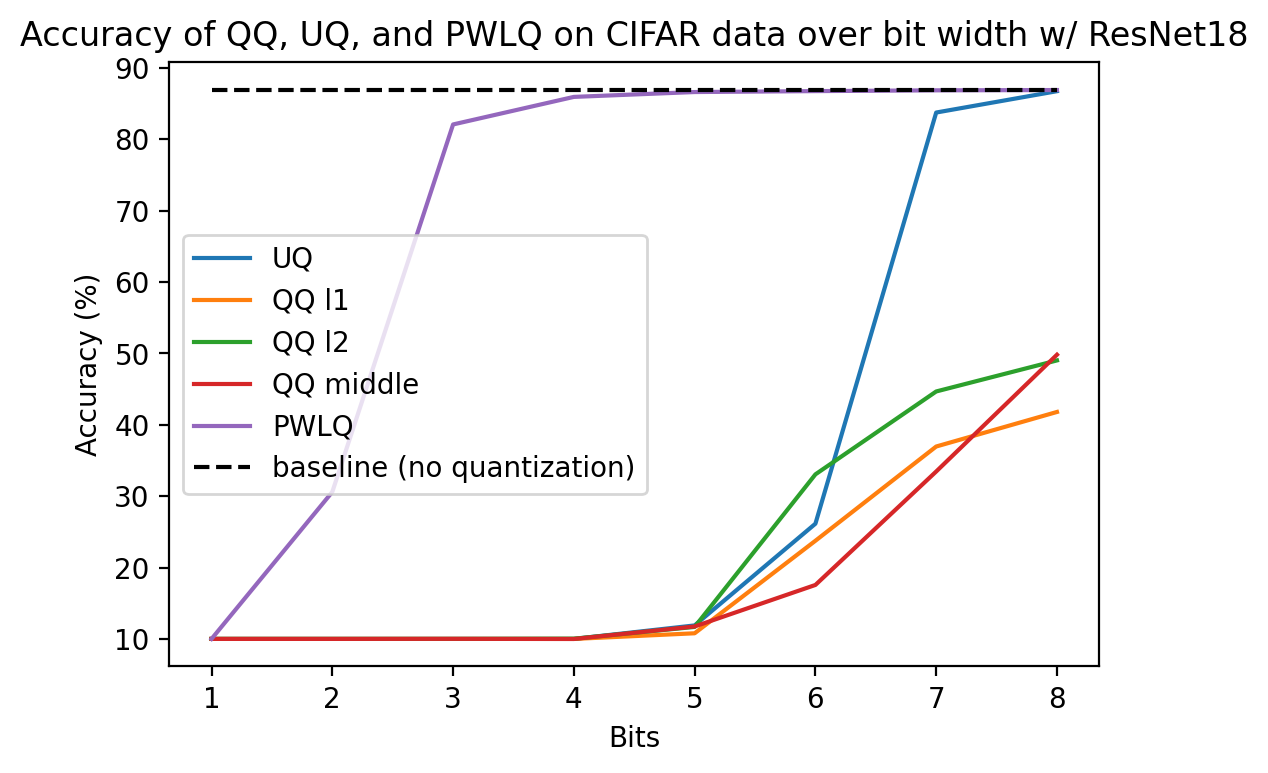

In [ ]:
x = range(1, 9)
plt.title("Accuracy of QQ, UQ, and PWLQ on CIFAR data over bit width w/ ResNet18")
plt.plot(x, uq_accuracies, label="UQ")
plt.plot(x, qq_l1s, label="QQ l1")
plt.plot(x, qq_l2s, label="QQ l2")
plt.plot(x, qq_middles, label="QQ middle")
plt.plot(x, pwlq_accuracies, label="PWLQ")
plt.plot(x, [baseline_acc for _ in x], "k--", label="baseline (no quantization)")
plt.xlabel("Bits")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

11689512
Plotting!
100000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


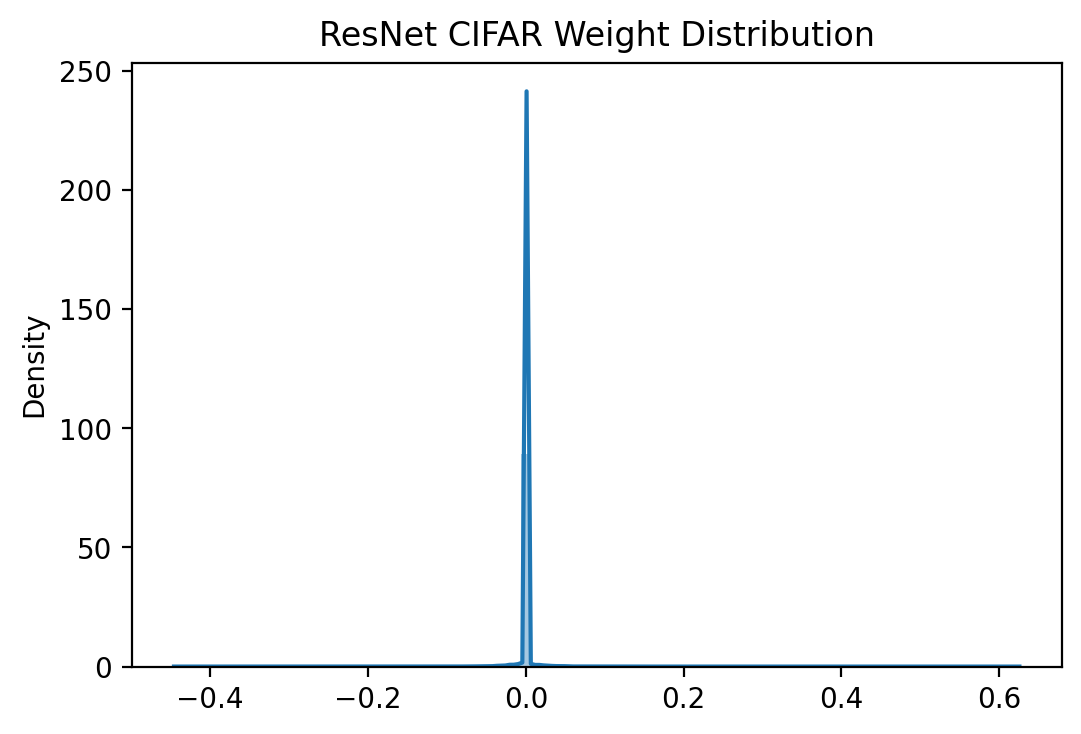

In [ ]:
import random
state_dict = resnet18.state_dict()
all_weights = []
for i, v in state_dict.items():
    if "weight" in i or "bias" in i:
        weights = v.cpu().numpy()
        all_weights.extend(list(weights.flatten()))

print(len(all_weights))
data = random.sample(all_weights, 100_000)
print("Plotting!")
print(len(data))
# plt.hist(data)
sns.distplot(data, bins=100)
plt.title("ResNet CIFAR Weight Distribution")
plt.show()

# Testing on ImageNette and ImageWoof



*   Download imagenette and imagewoof data  
*   Code up a class that runs all the tests we wan



In [ ]:
# Download ImageNette and ImageWoof data

! curl https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz --output imagenette.tgz
! tar zxvf imagenette.tgz

! curl https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz --output imagewoof.tqz
! tar zxvf imagewoof.tqz

In [ ]:
# Need a target transform for data loader, for this we need the imageNet classes and their indeces

! curl https://files.fast.ai/models/imagenet_class_index.json --output imagenetNames.json

with open("imagenetNames.json") as f:
    idx_label = json.load(f)

imagenet_ncode_to_target = {label[0]: int(idx) for idx, label in idx_label.items()}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35363  100 35363    0     0   204k      0 --:--:-- --:--:-- --:--:--  204k


In [ ]:
# Data loader for Nette and Woof data

def imagenet_like_loader(folder_name, batch_size, train=False):
    root = os.path.join(folder_name, "train" if train else "val")

    code_list = os.listdir(root)
    code_list.sort()
    old_target_to_code = {idx:k for idx, k in enumerate(code_list)}

    def target_transform(target):
        return imagenet_ncode_to_target[old_target_to_code[target]]

    mean = [0.485, 0.456, 0.406]
    stdv = [0.229, 0.224, 0.225]
    if train:
        transform = torchvision.transforms.Compose([
            # torchvision.transforms.Resize(256),
            # torchvision.transforms.RandomCrop(224),
            torchvision.transforms.RandomResizedCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, stdv)
        ])
    else:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, stdv)
        ])
    dataset = torchvision.datasets.ImageFolder(root=root, transform=transform, target_transform=target_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train)
    return dataloader

In [ ]:
nette_test_loader = imagenet_like_loader('imagenette2', 128)
woof_test_loader = imagenet_like_loader('imagewoof2', 128)

In [ ]:
# Loading pretrained models

pretrained_resnet50 = torchvision.models.resnet50(pretrained = True, progress = True) 
pretrained_mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained = True, progress = True) 
pretrained_mobilenet_v3_small = torchvision.models.mobilenet_v3_small(pretrained = True, progress = True) 
pretrained_mobilenet_v3_large = torchvision.models.mobilenet_v3_large(pretrained = True, progress = True) 
pretrained_googlenet = torchvision.models.googlenet(pretrained = True, progress = True) 

# Moving pretrained models to GPU CUDAs

pretrained_resnet50.cuda()
pretrained_mobilenet_v2.cuda()
pretrained_mobilenet_v3_small.cuda()
pretrained_mobilenet_v3_large.cuda()
pretrained_googlenet.cuda()

In [ ]:
def train_pretrained_model(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_pretrained_model(model, device, test_loader, verbose=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        
    return 100. * correct / len(test_loader.dataset)
    
device = torch.device("cuda")


In [ ]:
def quantize_model(model, bits, quant_type):

    model_copy = copy.deepcopy(model)

    model_copy.cpu()
    state_dict = model_copy.state_dict()
    quantized_dict = {} 
    
    for key, tensor in state_dict.items():
        if "weight" in key or "bias" in key:
            if quant_type == "qq":
                array = tensor.numpy()
                quantizer = QQ(array, bits)
                weights = torch.from_numpy(quantizer.quantize(array, qtype='l2'))

            elif quant_type == "uq":
                array = tensor.numpy()
                quantizer = UQ(array, bits)
                weights = torch.from_numpy(quantizer.quantize(array))

            elif quant_type == "pwlq":
                quantizer = PWLQ(tensor, bits=bits-1)
                weights = quantizer.piecewise_linear_quant(tensor, bits=bits-1)[0]
        else:
            weights = tensor
      
        quantized_dict[key] = weights

    model_copy.load_state_dict(quantized_dict)
    model_copy.cuda()
    return model_copy

In [ ]:
class QuantizePretrainedModel():
    def __init__(self, model, test_loader, bit_range, device):

        print("## starting tests ##")
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.bit_range = bit_range

        self.quantized_acc = {'qq':[], 'uq':[], 'pwlq':[]}
        self.baseline_score = test_pretrained_model(model, device, test_loader)

  
        print(f'baseline score = {np.round(self.baseline_score, 2)}%')
        format_row = "{:<12} {:<7} {:<7} {:<7}"
        print(format_row.format('bitwidth', 'uq', 'qq', 'pwlq'))

        for bits in bit_range:
            uq_acc = test_pretrained_model(quantize_model(model, bits, quant_type="uq"), device, test_loader)
            qq_acc = test_pretrained_model(quantize_model(model, bits, quant_type="qq"), device, test_loader)
            
            if bits >= 3:
                pwlq_acc = test_pretrained_model(quantize_model(model, bits, quant_type="pwlq"), device, test_loader)
                self.quantized_acc['pwlq'].append(np.round(pwlq_acc, 2))
            else:
                pwlq_acc = np.nan
                self.quantized_acc['pwlq'].append(np.nan)

            self.quantized_acc['uq'].append(np.round(uq_acc, 2))
            self.quantized_acc['qq'].append(np.round(qq_acc, 2))

            print(format_row.format(str(bits), str(uq_acc), str(qq_acc), str(pwlq_acc)))

    def plot_results(self, ax):
        bl = ax.axhline(y = self.baseline_score, color = 'k', linestyle = '--')
        uq_plt, = ax.plot(self.bit_range, self.quantized_acc['uq'])
        qq_plt, = ax.plot(self.bit_range, self.quantized_acc['qq'])
        pwlq_plt, = ax.plot(self.bit_range, self.quantized_acc['pwlq'])

        ax.legend([bl, uq_plt, qq_plt, pwlq_plt], ['Baseline', 'UQ', 'QQ', 'PWLQ'])
        ax.set_xlabel('bit width')
        ax.set_ylabel('Accuracy (%)');

    def histogram_weights(self, ax, xlims):
        state_dict = self.model.state_dict()
        all_weights = []
        for key, val in state_dict.items():
            weights = v.numpy()
            all_weights.extend(weights.flatten())
        
        ax.hist(all_weights, bins = 100)
        ax.set_xlim(xlims)
        

In [ ]:

state_dict = model.state_dict()
all_weights = []
for i, v in state_dict.items():
    weights = v.numpy()
    all_weights.extend(weights.flatten())

fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(all_weights, bins = 100);

In [ ]:
resnet50_tests = QuantizePretrainedModel(pretrained_resnet50, nette_test_loader, np.arange(1,9,1), device)

In [ ]:
def plot_results(self, ax):
    bl = ax.axhline(y = self.baseline_score, color = 'k', linestyle = '--')
    uq_plt, = ax.plot(self.bit_range, self.quantized_acc['uq'])
    qq_plt, = ax.plot(self.bit_range, self.quantized_acc['qq'])
    pwlq_plt, = ax.plot(self.bit_range, self.quantized_acc['pwlq'])

    ax.legend([bl, uq_plt, qq_plt, pwlq_plt], ['Baseline', 'UQ', 'QQ', 'PWLQ'])
    ax.set_xlabel('bit width')
    ax.set_ylabel('Accuracy (%)');

#Mobile Net v3 Large:

In [ ]:
mobilenet_tests = QuantizePretrainedModel(pretrained_mobilenet_v3_large, nette_test_loader, np.arange(1,9,1), device)

## starting tests ##
baseline score = 92.59%
bitwidth     uq      qq      pwlq   
1            0.0     0.0     nan    
2            0.0     0.0     nan    
3            0.0     0.0     0.0    
4            0.12738853503184713 0.0     0.025477707006369428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


5            12.9171974522293 0.0     13.070063694267516
6            66.7515923566879 0.0     70.64968152866243
7            88.71337579617834 5.1210191082802545 89.22292993630573
8            91.6687898089172 21.656050955414013 91.7452229299363


In [ ]:
list(state_dict.keys())[243]

'features.13.block.1.1.weight'

In [ ]:
[(idx, np.prod(val.numpy().shape)) for idx, val in enumerate(state_dict.values())]

[(0, 432),
 (1, 16),
 (2, 16),
 (3, 16),
 (4, 16),
 (5, 1.0),
 (6, 144),
 (7, 16),
 (8, 16),
 (9, 16),
 (10, 16),
 (11, 1.0),
 (12, 256),
 (13, 16),
 (14, 16),
 (15, 16),
 (16, 16),
 (17, 1.0),
 (18, 1024),
 (19, 64),
 (20, 64),
 (21, 64),
 (22, 64),
 (23, 1.0),
 (24, 576),
 (25, 64),
 (26, 64),
 (27, 64),
 (28, 64),
 (29, 1.0),
 (30, 1536),
 (31, 24),
 (32, 24),
 (33, 24),
 (34, 24),
 (35, 1.0),
 (36, 1728),
 (37, 72),
 (38, 72),
 (39, 72),
 (40, 72),
 (41, 1.0),
 (42, 648),
 (43, 72),
 (44, 72),
 (45, 72),
 (46, 72),
 (47, 1.0),
 (48, 1728),
 (49, 24),
 (50, 24),
 (51, 24),
 (52, 24),
 (53, 1.0),
 (54, 1728),
 (55, 72),
 (56, 72),
 (57, 72),
 (58, 72),
 (59, 1.0),
 (60, 1800),
 (61, 72),
 (62, 72),
 (63, 72),
 (64, 72),
 (65, 1.0),
 (66, 1728),
 (67, 24),
 (68, 1728),
 (69, 72),
 (70, 2880),
 (71, 40),
 (72, 40),
 (73, 40),
 (74, 40),
 (75, 1.0),
 (76, 4800),
 (77, 120),
 (78, 120),
 (79, 120),
 (80, 120),
 (81, 1.0),
 (82, 3000),
 (83, 120),
 (84, 120),
 (85, 120),
 (86, 120),
 (87,

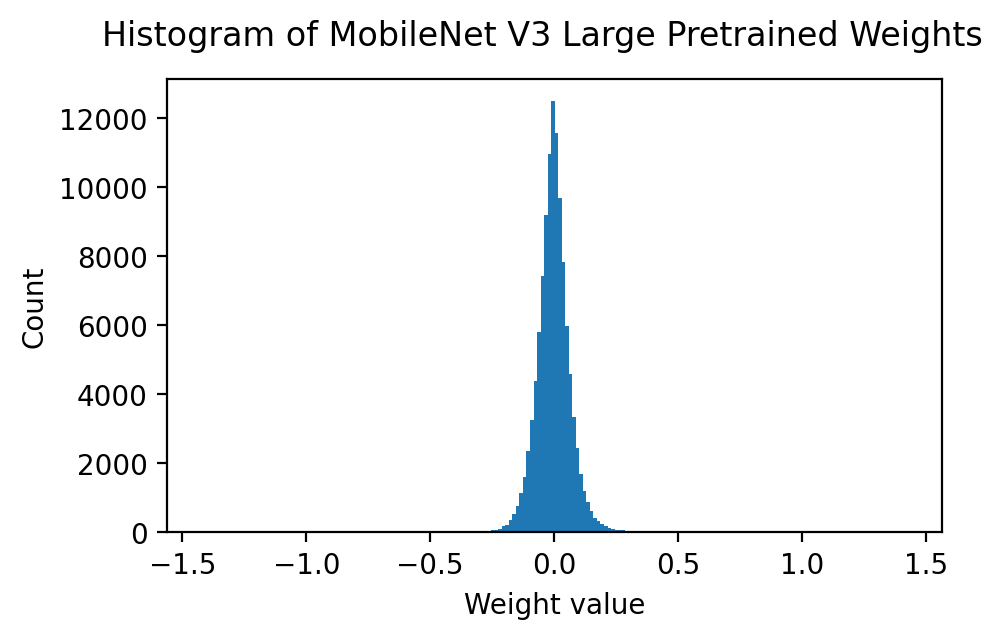

In [ ]:
# pretrained_mobilenet_v3_large.cpu()
# state_dict = pretrained_mobilenet_v3_large.state_dict()
# all_weights = []
# for i, v in state_dict.items():
#     weights = v.numpy()
#     all_weights.extend(weights.flatten())

all_weights = np.array(all_weights)
fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(list(state_dict.values())[248].flatten(), bins = 200)
fig.suptitle("Histogram of MobileNet V3 Large Pretrained Weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Count")
plt.show()

In [ ]:
all_weights.mean()

5.183045365898671

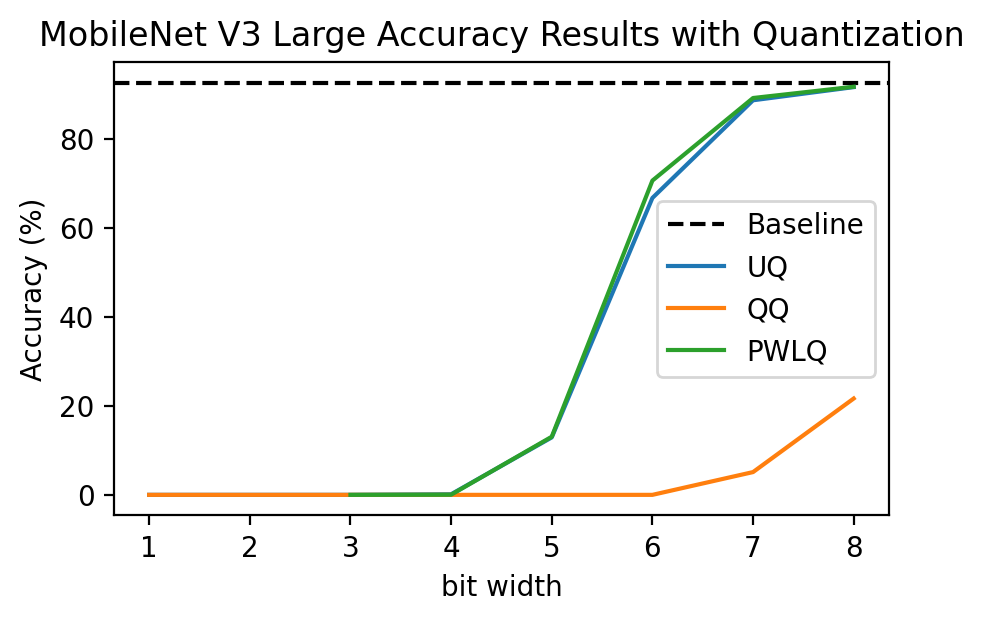

In [ ]:
fig, ax = plt.subplots(figsize = (5, 3))
plot_results(mobilenet_tests, ax)
plt.title("MobileNet V3 Large Accuracy Results with Quantization")
plt.show()

#Results on Google Net

In [ ]:
googlenet_tests = QuantizePretrainedModel(pretrained_googlenet, nette_test_loader, np.arange(1,9,1), device)

## starting tests ##
baseline score = 78.29%
bitwidth     uq      qq      pwlq   


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


1            0.0     0.0     nan    
2            0.0     0.0     nan    
3            0.0     0.0     0.0    
4            1.910828025477707 0.0     2.1910828025477707
5            42.496815286624205 0.0     66.11464968152866
6            71.97452229299363 0.5095541401273885 73.12101910828025
7            76.76433121019109 6.114649681528663 77.4267515923567
8            78.34394904458598 34.29299363057325 77.75796178343948


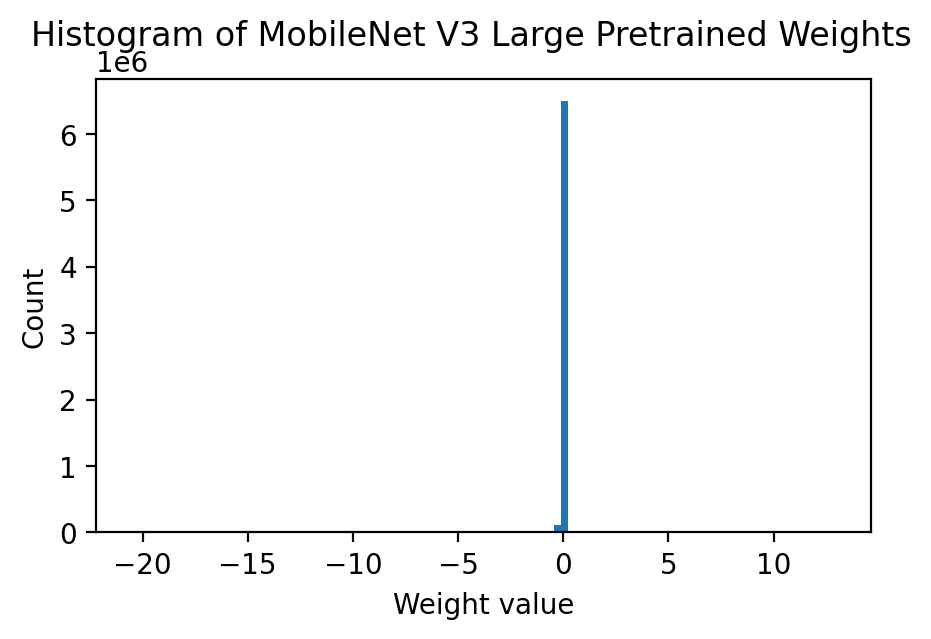

In [ ]:
pretrained_googlenet.cpu()
state_dict = pretrained_googlenet.state_dict()
all_weights = []
for i, v in state_dict.items():
    weights = v.numpy()
    all_weights.extend(weights.flatten())

fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(all_weights, bins = 100)
fig.suptitle("Histogram of MobileNet V3 Large Pretrained Weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Count")
plt.show()

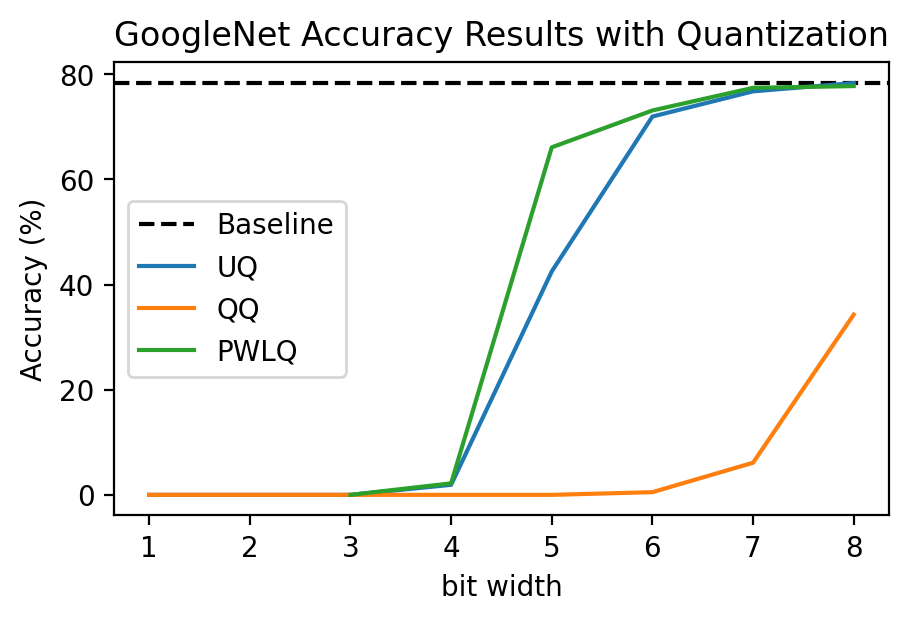

In [ ]:
fig, ax = plt.subplots(figsize = (5, 3))
mobilenet_tests.plot_results(ax)
plt.title("GoogleNet Accuracy Results with Quantization")
plt.show()

#Results on Mobile Net v3 Small

In [ ]:
mobilenet_small_tests = QuantizePretrainedModel(pretrained_mobilenet_v3_small, nette_test_loader, np.arange(1,9,1), device)

## starting tests ##
baseline score = 81.02%
bitwidth     uq      qq      pwlq   
1            0.0     0.0     nan    
2            0.0     0.0     nan    
3            0.07643312101910828 0.0     0.0    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


4            0.025477707006369428 0.025477707006369428 0.0    
5            0.5095541401273885 0.0     0.0    
6            48.22929936305732 0.025477707006369428 16.02547770700637
7            72.22929936305732 1.732484076433121 72.61146496815287
8            77.68152866242038 45.37579617834395 77.14649681528662


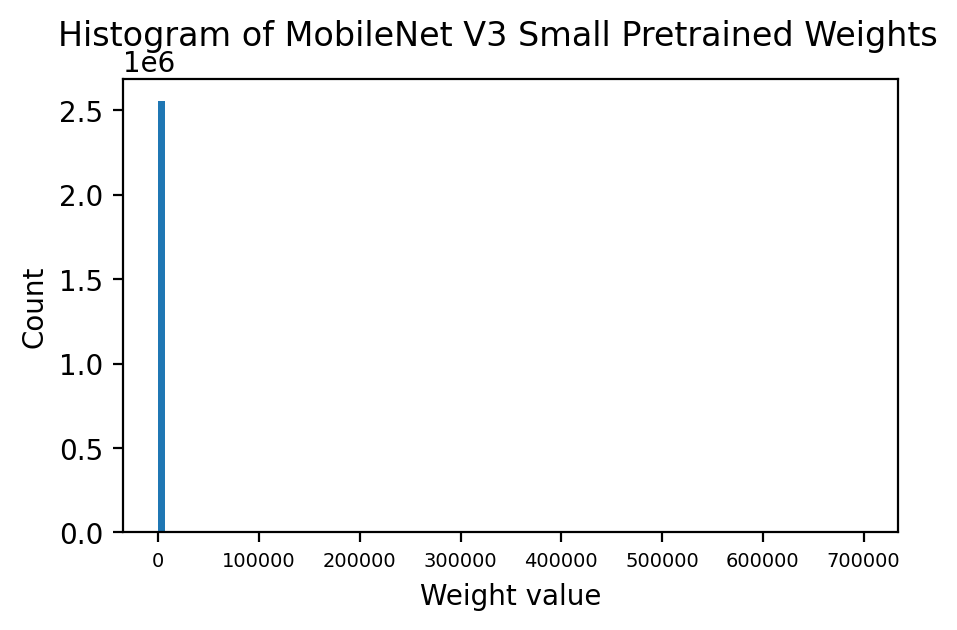

In [ ]:
pretrained_mobilenet_v3_small.cpu()
state_dict = pretrained_mobilenet_v3_small.state_dict()
all_weights = []
for i, v in state_dict.items():
    weights = v.numpy()
    all_weights.extend(weights.flatten())

fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(all_weights, bins = 100)
fig.suptitle("Histogram of MobileNet V3 Small Pretrained Weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Count")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(7) 
plt.show()

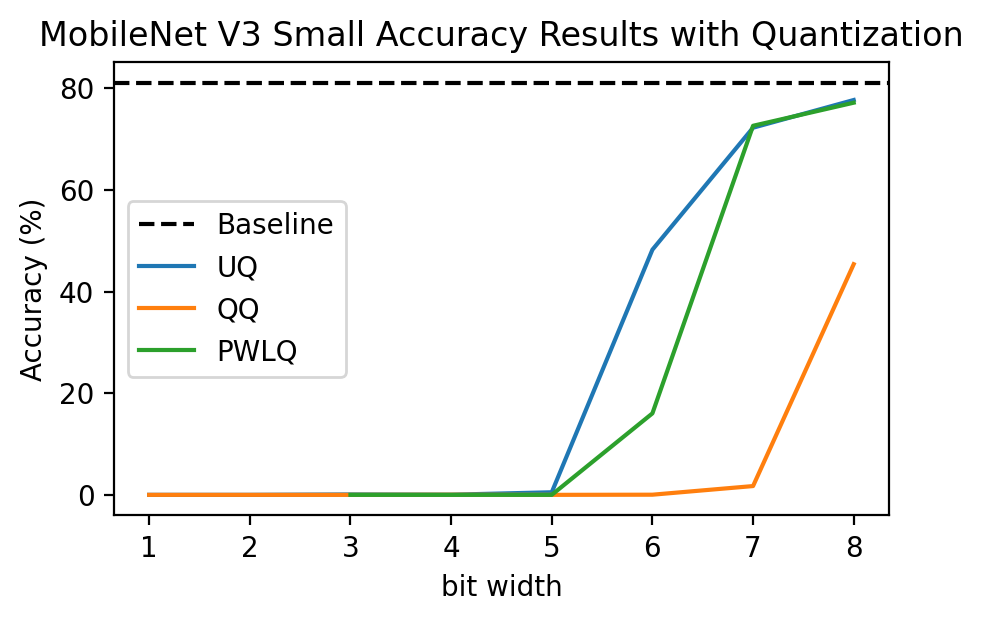

In [ ]:
fig, ax = plt.subplots(figsize = (5, 3))
mobilenet_small_tests.plot_results(ax)
plt.title("MobileNet V3 Small Accuracy Results with Quantization")
plt.show()

#Results on Resnet 50 


In [ ]:
pretrained_resnet_tests = QuantizePretrainedModel(pretrained_resnet50, nette_test_loader, np.arange(1,9,1), device)

## starting tests ##
baseline score = 88.61%
bitwidth     uq      qq      pwlq   
1            0.0     0.0     nan    
2            0.0     0.0     nan    
3            0.0     0.0     0.0    
4            0.0     0.0     23.97452229299363
5            3.3630573248407645 4.993630573248407 79.87261146496816
6            87.64331210191082 28.076433121019107 88.20382165605096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


7            89.4267515923567 62.29299363057325 88.8407643312102
8            89.22292993630573 79.56687898089172 88.12738853503184


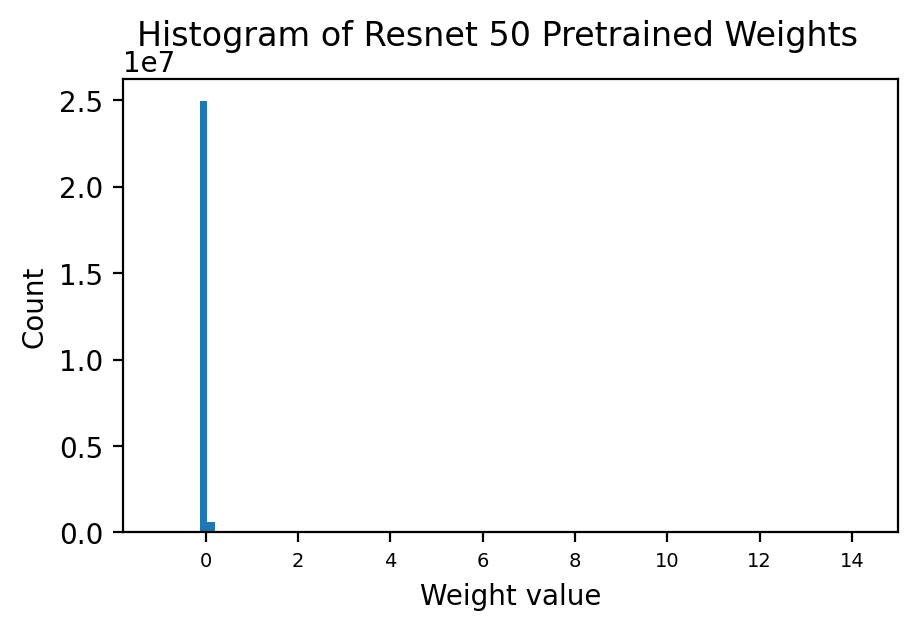

In [ ]:
pretrained_resnet50.cpu()
state_dict = pretrained_resnet50.state_dict()
all_weights = []
for i, v in state_dict.items():
    weights = v.numpy()
    all_weights.extend(weights.flatten())

fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(all_weights, bins = 100)
fig.suptitle("Histogram of Resnet 50 Pretrained Weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Count")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(7) 
plt.show()

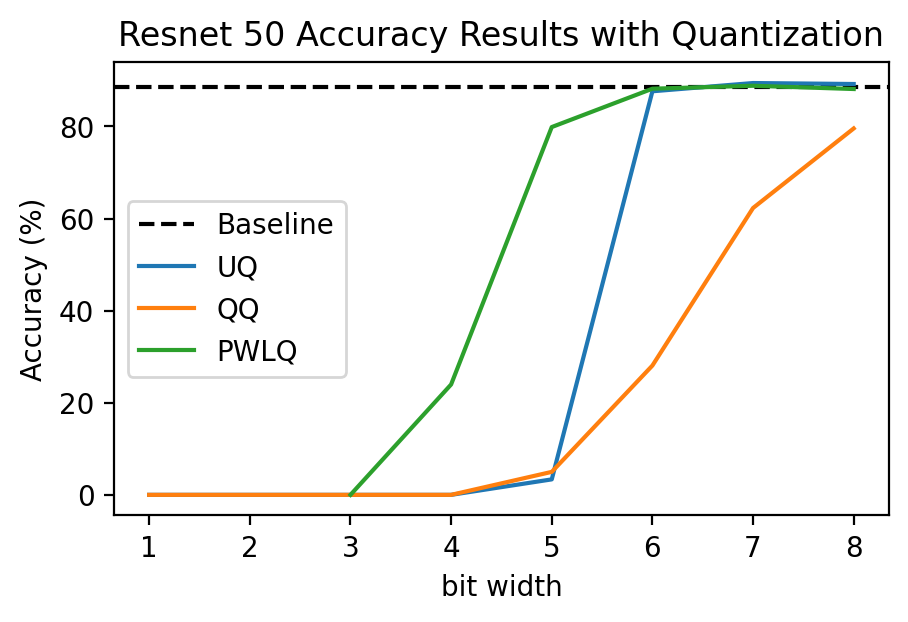

In [ ]:
fig, ax = plt.subplots(figsize = (5, 3))
pretrained_resnet_tests.plot_results(ax)
plt.title("Resnet 50 Accuracy Results with Quantization")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(all_weights, bins = 100)

In [ ]:
state_dict.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

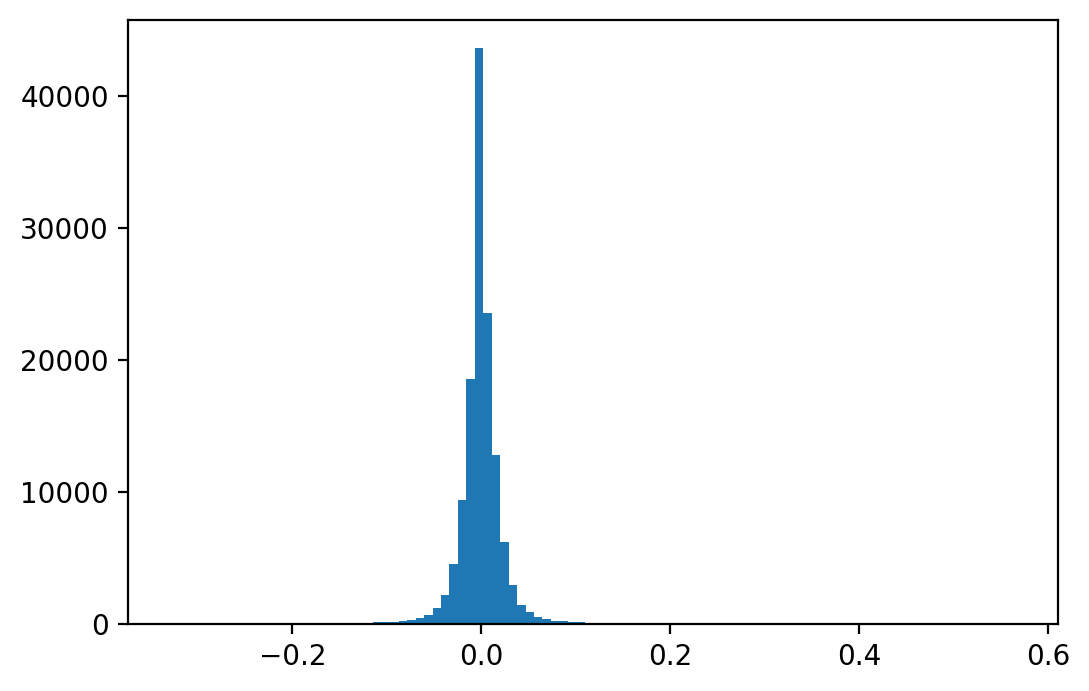

In [ ]:
plt.hist(state_dict['layer2.0.downsample.0.weight'].numpy().flatten(), bins = 100);

In [ ]:
test = UQ(state_dict['layer2.0.downsample.0.weight'], 3)

(tensor(-0.3291), tensor(0.6222), tensor(0.1119))


In [ ]:
bad = 'layer2.0.bn3.num_batches_tracked'

In [ ]:
'trcked' in bad

False

In [ ]:
pretrained_googlenet.state_dict().keys()

odict_keys(['conv1.conv.weight', 'conv1.bn.weight', 'conv1.bn.bias', 'conv1.bn.running_mean', 'conv1.bn.running_var', 'conv1.bn.num_batches_tracked', 'conv2.conv.weight', 'conv2.bn.weight', 'conv2.bn.bias', 'conv2.bn.running_mean', 'conv2.bn.running_var', 'conv2.bn.num_batches_tracked', 'conv3.conv.weight', 'conv3.bn.weight', 'conv3.bn.bias', 'conv3.bn.running_mean', 'conv3.bn.running_var', 'conv3.bn.num_batches_tracked', 'inception3a.branch1.conv.weight', 'inception3a.branch1.bn.weight', 'inception3a.branch1.bn.bias', 'inception3a.branch1.bn.running_mean', 'inception3a.branch1.bn.running_var', 'inception3a.branch1.bn.num_batches_tracked', 'inception3a.branch2.0.conv.weight', 'inception3a.branch2.0.bn.weight', 'inception3a.branch2.0.bn.bias', 'inception3a.branch2.0.bn.running_mean', 'inception3a.branch2.0.bn.running_var', 'inception3a.branch2.0.bn.num_batches_tracked', 'inception3a.branch2.1.conv.weight', 'inception3a.branch2.1.bn.weight', 'inception3a.branch2.1.bn.bias', 'inception3a.